<a href="https://colab.research.google.com/github/Trading-com-Dados/desenvolvimento_interno/blob/main/JPJ/BACKTRADER_Biblioteca_especializada_em_backtesting_de_estrat%C3%A9gias_com_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://tradingcomdados.com/images/logotipo/logotipo-trading-com-dados.svg" width="300">

---
# **BACKTRADER: Biblioteca especializada em backtesting de estratégias com Python** 
---
#### *Disclaimer:*
#### Este código foi elaborado para fins exclusivamente educacionais. O conteúdo aqui apresentado visa fornecer informações complementares para auxiliar o investidor na tomada de suas próprias decisões de investimento. Reforçando, nenhum tópico aqui abordado constitui qualquer tipo de indicação/oferta/solicitação de compra/venda de qualquer produto.
---


# **1. Bibliotecas utilizadas**

In [399]:
!pip install yfinance
!pip install ta
!pip install backtrader

     |████████████████████████████████| 410 kB 16.9 MB/s 


In [400]:
import numpy as np
import pandas as pd
from datetime import datetime
import pytz

import yfinance as yf
import ta
import backtrader as bt

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# %matplotlib inline

# **2. Criar o dataset**

## **2.1. Yahoo Finance - yfinance**

In [472]:
## Importar os dados de cotações do Yahoo Finance

# df_1D = yf.download('BTC-USD', period='max', interval = '1d')
df_1D = yf.download('BTC-USD', start='2021-01-01', end = '2021-03-31', interval = '1d')
df_1D

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782
...,...,...,...,...,...,...
2021-03-27,55137.566406,56568.214844,54242.910156,55973.511719,55973.511719,47266542233
2021-03-28,55974.941406,56610.312500,55071.113281,55950.746094,55950.746094,47686580918
2021-03-29,55947.898438,58342.097656,55139.339844,57750.199219,57750.199219,57625587027


## **2.5. Tranformar em Data Feeds**

In [446]:
data = bt.feeds.PandasData(dataname=df_1D, name='BTC-USD')

## 2.1. Definir sinais de Entrada 

In [447]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
    ('myparam', 27),
    ('exitbars', 5),
)

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + self.params.exitbars):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [448]:
cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.addstrategy(TestStrategy)

## Estabelecer parâmetros do broker
cerebro.broker.setcash(1000000)
cerebro.addsizer(bt.sizers.SizerFix, stake=1)

'''
Taxas:
MARGIN (default None)= cash necessário para operações envolvendo mercado futuro
COMISSION (default 0.0): 
Se MARGIN = FALSE: *commission* representa uma porcentagem do volume financeiro de negociação (price * size) (ex., emolumentos de ações e taxas de liquidação)
Se MARGIN = qq valor ou None: *commission* é fixa por contrato (ex. corretagem). Lembrar q é compra/venda em cada operação fechada) 
MULT (default 1)= Fator de multiplicação aos lucros e perdas envolvendo mercados futuros (alavancagem)
'''
#cerebro.broker.setcommission(commission=1,margin=None,mult=1)

print('Valor inicial da carteira: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Valor final da carteira: %.2f' % cerebro.broker.getvalue())

Valor inicial da carteira: 1000000.00
2021-01-01, Close, 29374.15
2021-01-01, BUY CREATE, 29374.15
2021-01-02, BUY EXECUTED, Price: 29376.46, Cost: 29376.46, Comm 0.00
2021-01-02, Close, 32127.27
2021-01-03, Close, 32782.02
2021-01-04, Close, 31971.91
2021-01-05, Close, 33992.43
2021-01-06, Close, 36824.36
2021-01-07, Close, 39371.04
2021-01-07, SELL CREATE, 39371.04
2021-01-08, SELL EXECUTED, Price: 39381.77, Cost: 29376.46, Comm 0.00
2021-01-08, OPERATION PROFIT, GROSS 10005.31, NET 10005.31
2021-01-08, Close, 40797.61
2021-01-09, Close, 40254.55
2021-01-10, Close, 38356.44
2021-01-10, BUY CREATE, 38356.44
2021-01-11, BUY EXECUTED, Price: 38346.53, Cost: 38346.53, Comm 0.00
2021-01-11, Close, 35566.66
2021-01-12, Close, 33922.96
2021-01-13, Close, 37316.36
2021-01-14, Close, 39187.33
2021-01-15, Close, 36825.37
2021-01-16, Close, 36178.14
2021-01-16, SELL CREATE, 36178.14
2021-01-17, SELL EXECUTED, Price: 36163.65, Cost: 38346.53, Comm 0.00
2021-01-17, OPERATION PROFIT, GROSS -2182.8

<IPython.core.display.Javascript object>

[[<Figure size 1080x864 with 4 Axes>]]

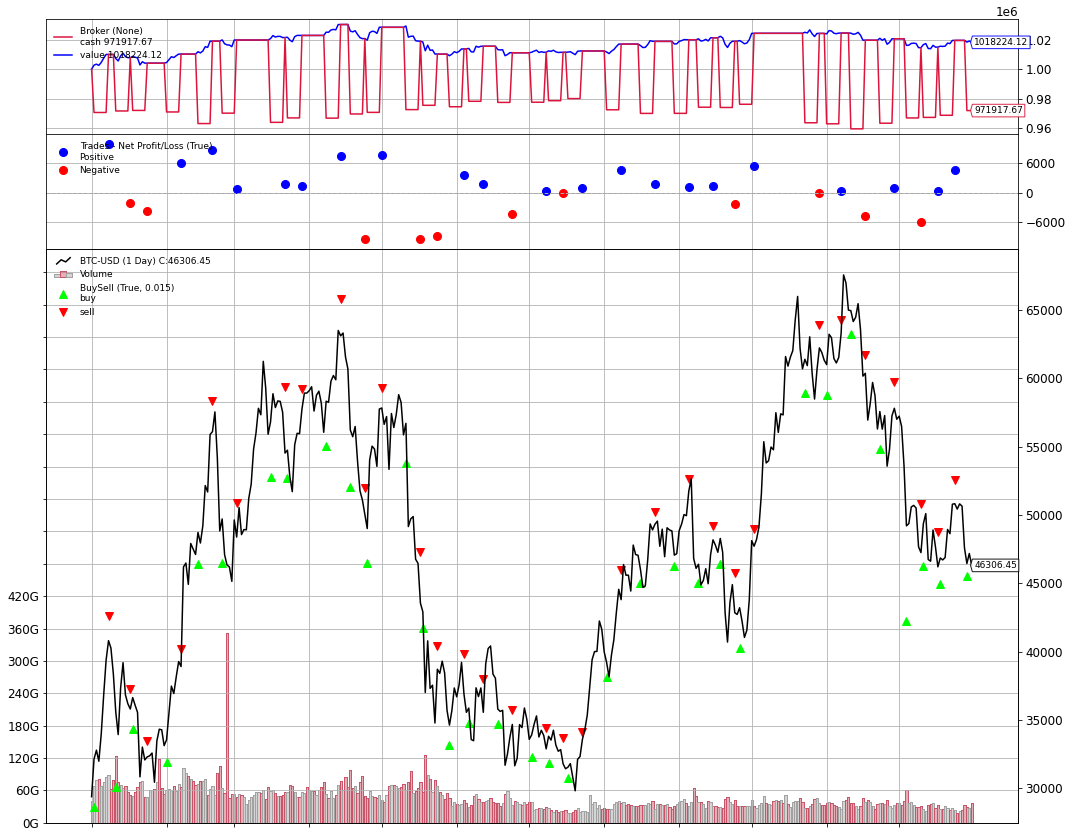

In [451]:
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams.update({'font.size': 12})
cerebro.plot()

## Indicador MM

In [452]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [453]:
cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.addstrategy(TestStrategy)

## Estabelecer parâmetros do broker
cerebro.broker.setcash(1000000)
cerebro.addsizer(bt.sizers.SizerFix, stake=1)

'''
Taxas:
MARGIN (default None)= cash necessário para operações envolvendo mercado futuro
COMISSION (default 0.0): 
Se MARGIN = FALSE: *commission* representa uma porcentagem do volume financeiro de negociação (price * size) (ex., emolumentos de ações e taxas de liquidação)
Se MARGIN = qq valor ou None: *commission* é fixa por contrato (ex. corretagem). Lembrar q é compra/venda em cada operação fechada) 
MULT (default 1)= Fator de multiplicação aos lucros e perdas envolvendo mercados futuros (alavancagem)
'''
#cerebro.broker.setcommission(commission=1,margin=None,mult=1)

print('Valor inicial da carteira: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Valor final da carteira: %.2f' % cerebro.broker.getvalue())

Valor inicial da carteira: 1000000.00
2021-01-15, Close, 36825.37
2021-01-15, BUY CREATE, 36825.37
2021-01-16, BUY EXECUTED, Price: 36821.65, Cost: 36821.65, Comm 0.00
2021-01-16, Close, 36178.14
2021-01-16, SELL CREATE, 36178.14
2021-01-17, SELL EXECUTED, Price: 36163.65, Cost: 36821.65, Comm 0.00
2021-01-17, OPERATION PROFIT, GROSS -658.00, NET -658.00
2021-01-17, Close, 35791.28
2021-01-18, Close, 36630.07
2021-01-19, Close, 36069.80
2021-01-20, Close, 35547.75
2021-01-21, Close, 30825.70
2021-01-22, Close, 33005.76
2021-01-23, Close, 32067.64
2021-01-24, Close, 32289.38
2021-01-25, Close, 32366.39
2021-01-26, Close, 32569.85
2021-01-27, Close, 30432.55
2021-01-28, Close, 33466.10
2021-01-29, Close, 34316.39
2021-01-29, BUY CREATE, 34316.39
2021-01-30, BUY EXECUTED, Price: 34295.93, Cost: 34295.93, Comm 0.00
2021-01-30, Close, 34269.52
2021-01-31, Close, 33114.36
2021-01-31, SELL CREATE, 33114.36
2021-02-01, SELL EXECUTED, Price: 33114.58, Cost: 34295.93, Comm 0.00
2021-02-01, OPERA

<IPython.core.display.Javascript object>

[[<Figure size 1080x864 with 4 Axes>]]

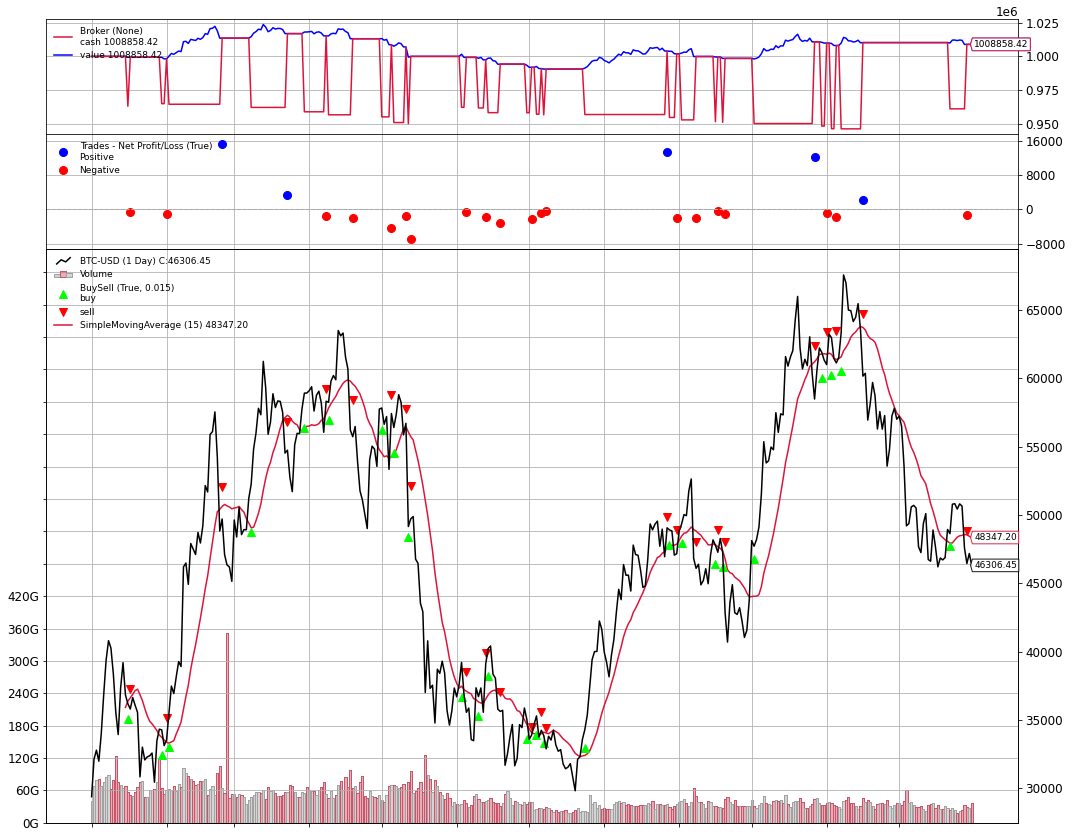

In [454]:
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams.update({'font.size': 12})
cerebro.plot()

## RANGE DE MÉDIAS MOVEIS (optstrategy)

In [456]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [457]:
cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.optstrategy(TestStrategy, maperiod=range(10, 31))

## Estabelecer parâmetros do broker
cerebro.broker.setcash(1000000)
cerebro.addsizer(bt.sizers.SizerFix, stake=1)

'''
Taxas:
MARGIN (default None)= cash necessário para operações envolvendo mercado futuro
COMISSION (default 0.0): 
Se MARGIN = FALSE: *commission* representa uma porcentagem do volume financeiro de negociação (price * size) (ex., emolumentos de ações e taxas de liquidação)
Se MARGIN = qq valor ou None: *commission* é fixa por contrato (ex. corretagem). Lembrar q é compra/venda em cada operação fechada) 
MULT (default 1)= Fator de multiplicação aos lucros e perdas envolvendo mercados futuros (alavancagem)
'''
#cerebro.broker.setcommission(commission=1,margin=None,mult=1)

print('Valor inicial da carteira: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Valor final da carteira: %.2f' % cerebro.broker.getvalue())

A saída de streaming foi truncada nas últimas 5000 linhas.
2021-11-17, SELL EXECUTED, Price: 60139.62, Cost: 63344.07, Comm 0.00
2021-09-16, BUY EXECUTED, Price: 48158.91, Cost: 48158.91, Comm 0.00
2021-09-16, Close, 47783.36
2021-09-16, SELL CREATE, 47783.36
2021-11-17, OPERATION PROFIT, GROSS -3204.45, NET -3204.45
2021-09-17, SELL EXECUTED, Price: 47771.00, Cost: 48158.91, Comm 0.00
2021-11-17, Close, 60368.01
2021-11-18, Close, 56942.14
2021-09-17, OPERATION PROFIT, GROSS -387.90, NET -387.90
2021-09-17, Close, 47267.52
2021-11-19, Close, 58119.58
2021-09-18, Close, 48278.36
2021-11-20, Close, 59697.20
2021-09-18, BUY CREATE, 48278.36
2021-11-21, Close, 58730.48
2021-11-22, Close, 56289.29
2021-09-19, BUY EXECUTED, Price: 48268.86, Cost: 48268.86, Comm 0.00
2021-11-23, Close, 57569.07
2021-09-19, Close, 47260.22
2021-11-24, Close, 56280.43
2021-09-19, SELL CREATE, 47260.22
2021-11-25, Close, 57274.68
2021-11-26, Close, 53569.77
2021-09-20, SELL EXECUTED, Price: 47261.41, Cost: 4826

In [481]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                #self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
             # SELL, SELL, SELL!!! (with all possible default parameters)
                #self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

Valor inicial da carteira: 1000000.00
2021-01-11, BUY EXECUTED, Price: 38346.53, Cost: 38346.53, Comm 0.00
2021-01-12, SELL EXECUTED, Price: 35516.36, Cost: 38346.53, Comm 0.00
2021-01-12, OPERATION PROFIT, GROSS -2830.17, NET -2830.17
2021-01-14, BUY EXECUTED, Price: 37325.11, Cost: 37325.11, Comm 0.00
2021-01-16, SELL EXECUTED, Price: 36821.65, Cost: 37325.11, Comm 0.00
2021-01-16, OPERATION PROFIT, GROSS -503.46, NET -503.46
2021-01-29, BUY EXECUTED, Price: 34318.67, Cost: 34318.67, Comm 0.00
2021-02-24, SELL EXECUTED, Price: 48835.09, Cost: 34318.67, Comm 0.00
2021-02-24, OPERATION PROFIT, GROSS 14516.41, NET 14516.41
2021-03-04, BUY EXECUTED, Price: 50522.30, Cost: 50522.30, Comm 0.00
2021-03-22, SELL EXECUTED, Price: 57517.89, Cost: 50522.30, Comm 0.00
2021-03-22, OPERATION PROFIT, GROSS 6995.59, NET 6995.59
2021-03-28, BUY EXECUTED, Price: 55974.94, Cost: 55974.94, Comm 0.00
2021-04-07, SELL EXECUTED, Price: 58186.51, Cost: 55974.94, Comm 0.00
2021-04-07, OPERATION PROFIT, GROSS

In [491]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
        ('printlog', False),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.maperiod, self.broker.getvalue()), doprint=True)

In [492]:
cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.optstrategy(TestStrategy, maperiod=range(10, 31))

## Estabelecer parâmetros do broker
cerebro.broker.setcash(1000000)
cerebro.addsizer(bt.sizers.SizerFix, stake=1)

'''
Taxas:
MARGIN (default None)= cash necessário para operações envolvendo mercado futuro
COMISSION (default 0.0): 
Se MARGIN = FALSE: *commission* representa uma porcentagem do volume financeiro de negociação (price * size) (ex., emolumentos de ações e taxas de liquidação)
Se MARGIN = qq valor ou None: *commission* é fixa por contrato (ex. corretagem). Lembrar q é compra/venda em cada operação fechada) 
MULT (default 1)= Fator de multiplicação aos lucros e perdas envolvendo mercados futuros (alavancagem)
'''
#cerebro.broker.setcommission(commission=1,margin=None,mult=1)

print('Valor inicial da carteira: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Valor final da carteira: %.2f' % cerebro.broker.getvalue())

Valor inicial da carteira: 1000000.00


FileNotFoundError: ignored

---
**Vamos backtestar os setups abaixo e comparar os resultados**

---

**Preço de fechamento de reversão**

Sinal de Entrada:<p>
1) Quando a mínima do candle atual for menor do que a mínima dos dois últimos candles prévios e; <p>
2) o fechamento do candle atual for maior do que o fechamento do candle anterior.

**123 de compra simples**

Sinal de Entrada:<p>
1) Um candle que tenha a mínima menor que a mínima do candle anterior e; <p>
2) Vamos comprar na superação da máxima desse candle formando os três candles e, <p>
3) Isso em cima da MM9 ascendente.

## 2.2. Baixar os dados de Bitcoin pela yfinance para Data Feeds

In [401]:
# Bitcoin pelo Yahoo Finance só em dolar
# Dependendo do horário em que o código for rodado, os candles já corresponderão ao dia posterior (fuso UTC)

cotacoes_BTC_yf = yf.download("BTC-USD", start = '2018-01-01', end = '2021-12-31', interval = "1d")

data = bt.feeds.PandasData(dataname=cotacoes_BTC_yf, name='BTC-USD')

[*********************100%***********************]  1 of 1 completed


In [402]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)


import backtrader as bt
import backtrader.indicators as btind


class MA_CrossOver(bt.Strategy):
    '''This is a long-only strategy which operates on a moving average cross
    Note:
      - Although the default
    Buy Logic:
      - No position is open on the data
      - The ``fast`` moving averagecrosses over the ``slow`` strategy to the
        upside.
    Sell Logic:
      - A position exists on the data
      - The ``fast`` moving average crosses over the ``slow`` strategy to the
        downside
    Order Execution Type:
      - Market
    '''
    alias = ('SMA_CrossOver',)

    params = (
        # period for the fast Moving Average
        ('fast', 10),
        # period for the slow moving average
        ('slow', 30),
        # moving average to use
        ('_movav', btind.MovAv.SMA)
    )

    def __init__(self):
        sma_fast = self.p._movav(period=self.p.fast)
        sma_slow = self.p._movav(period=self.p.slow)

        self.buysig = btind.CrossOver(sma_fast, sma_slow)

    def next(self):
        if self.position.size:
            if self.buysig < 0:
                self.sell()

        elif self.buysig > 0:
            self.buy()

In [406]:
cerebro = bt.Cerebro()
cerebro.adddata(data)
cerebro.addstrategy(MA_CrossOver)

## Estabelecer parâmetros do broker
cerebro.broker.setcash(1000000)
cerebro.addsizer(bt.sizers.SizerFix, stake=1)

'''
Taxas:
MARGIN (default None)= cash necessário para operações envolvendo mercado futuro
COMISSION (default 0.0): 
Se MARGIN = FALSE: *commission* representa uma porcentagem do volume financeiro de negociação (price * size) (ex., emolumentos de ações e taxas de liquidação)
Se MARGIN = qq valor ou None: *commission* é fixa por contrato (ex. corretagem). Lembrar q é compra/venda em cada operação fechada) 
MULT (default 1)= Fator de multiplicação aos lucros e perdas envolvendo mercados futuros (alavancagem)
'''
cerebro.broker.setcommission(commission=0.00025,margin=False,mult=1)

print('Valor inicial da carteira: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Valor final da carteira: %.2f' % cerebro.broker.getvalue())

Valor inicial da carteira: 1000000.00
Valor final da carteira: 1028507.04


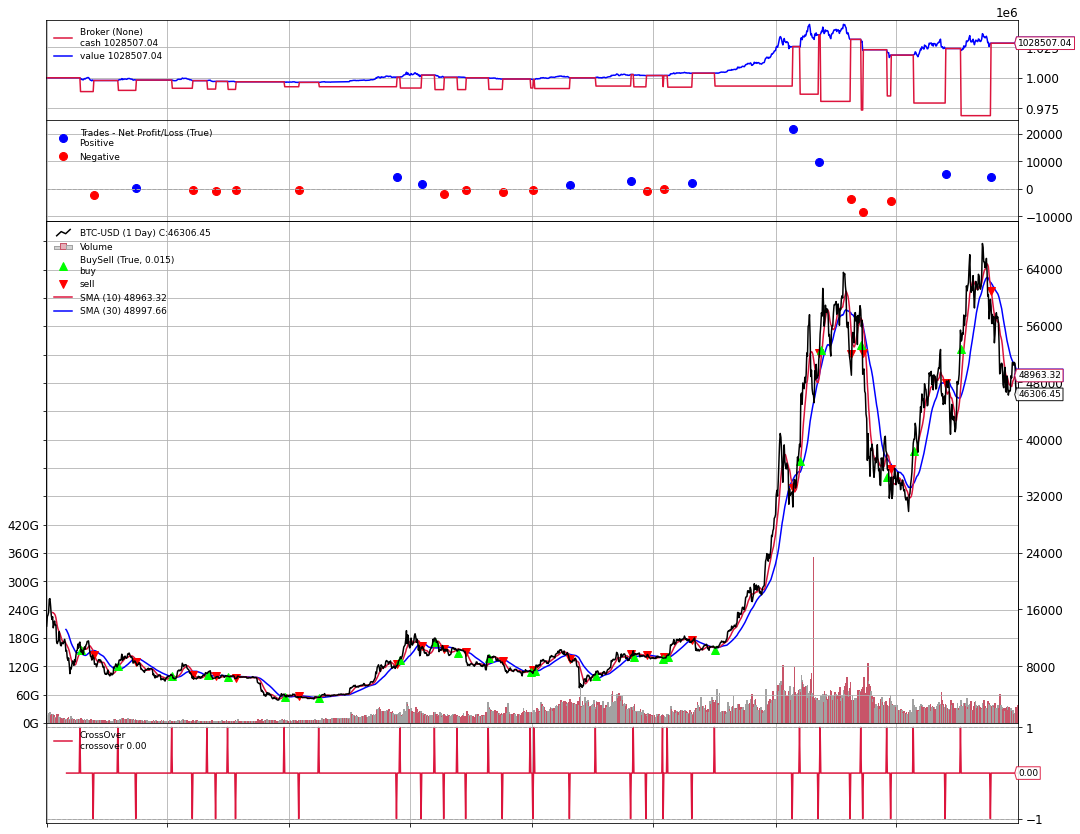

[[<Figure size 1080x864 with 5 Axes>]]

In [407]:
plt.rcParams['figure.figsize'] = [15, 12]
plt.rcParams.update({'font.size': 12})
cerebro.plot(iplot = False)

# **3. Backtesting Setup Preço de fechamento de reversão (PFR)**

* Bitcoin USD<p>
* Timeframe diário<p>
* Entre Jan/2018 a Dez/2021

In [252]:
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072
...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299


**Preço de fechamento de reversão**

Sinal de Entrada:<p>
1) Quando a mínima do candle atual for menor do que a mínima dos dois últimos candles prévios e; <p>
2) O fechamento do candle atual for maior do que o fechamento do candle anterior.

**Regra 1:** Low2 < (Low1 e Low0)

**Regra 2:** Close2 > Close1

## **3.1. Sinais de entrada COMPRA**


**Regra 1:** Low2 < (Low1 e Low0)

In [253]:
min_2cd_ant = cotacoes_BTC_yf['Low'].rolling(window=2,closed="left").min()
cotacoes_BTC_yf['min_2cd_ant'] = min_2cd_ant

In [254]:
cotacoes_BTC_yf['Regra1'] = cotacoes_BTC_yf['Low'] <= cotacoes_BTC_yf['min_2cd_ant']
cotacoes_BTC_yf.head(10)

,Open,High,Low,Close,Adj Close,Volume,min_2cd_ant,Regra1
Date,,,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000,NaN,False
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,NaN,False
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,13154.700195,False
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,13163.599609,False
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072,14522.200195,False
2018-01-06,17462.099609,17712.400391,16764.599609,17527.000000,17527.000000,18314600448,14522.200195,False
2018-01-07,17527.300781,17579.599609,16087.700195,16477.599609,16477.599609,15866000384,15202.799805,False
2018-01-08,16476.199219,16537.900391,14208.200195,15170.099609,15170.099609,18413899776,16087.700195,True
2018-01-09,15123.700195,15497.500000,14424.000000,14595.400391,14595.400391,16659999744,14208.200195,False


**Regra 2:** Close2 > Close1

In [255]:
close_ant = cotacoes_BTC_yf['Close'].rolling(window=1,closed="left").mean()
cotacoes_BTC_yf['Close_ant'] = close_ant
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,min_2cd_ant,Regra1,Close_ant
Date,,,,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000,NaN,False,NaN
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,NaN,False,13657.200195
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,13154.700195,False,14982.099609
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,13163.599609,False,15201.000000
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072,14522.200195,False,15599.200195
...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,49623.105469,False,50809.515625
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,49623.105469,True,50640.417969
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,47414.210938,True,47588.855469


In [256]:
cotacoes_BTC_yf['Regra2'] = cotacoes_BTC_yf['Close'] > cotacoes_BTC_yf['Close_ant']
cotacoes_BTC_yf.head(10)

,Open,High,Low,Close,Adj Close,Volume,min_2cd_ant,Regra1,Close_ant,Regra2
Date,,,,,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000,NaN,False,NaN,False
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,NaN,False,13657.200195,True
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,13154.700195,False,14982.099609,True
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,13163.599609,False,15201.000000,True
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072,14522.200195,False,15599.200195,True
2018-01-06,17462.099609,17712.400391,16764.599609,17527.000000,17527.000000,18314600448,14522.200195,False,17429.500000,True
2018-01-07,17527.300781,17579.599609,16087.700195,16477.599609,16477.599609,15866000384,15202.799805,False,17527.000000,False
2018-01-08,16476.199219,16537.900391,14208.200195,15170.099609,15170.099609,18413899776,16087.700195,True,16477.599609,False
2018-01-09,15123.700195,15497.500000,14424.000000,14595.400391,14595.400391,16659999744,14208.200195,False,15170.099609,False


In [257]:
cotacoes_BTC_yf['Candle_sinal'] = cotacoes_BTC_yf['Regra1'] & cotacoes_BTC_yf['Regra2']
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,min_2cd_ant,Regra1,Close_ant,Regra2,Candle_sinal
Date,,,,,,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000,NaN,False,NaN,False,False
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,NaN,False,13657.200195,True,False
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,13154.700195,False,14982.099609,True,False
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,13163.599609,False,15201.000000,True,False
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072,14522.200195,False,15599.200195,True,False
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,49623.105469,False,50809.515625,False,False
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,49623.105469,True,50640.417969,False,False
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,47414.210938,True,47588.855469,False,False


In [258]:
candles_sinais = cotacoes_BTC_yf[cotacoes_BTC_yf.Candle_sinal == True]
candles_sinais

,Open,High,Low,Close,Adj Close,Volume,min_2cd_ant,Regra1,Close_ant,Regra2,Candle_sinal
Date,,,,,,,,,,,
2018-01-10,14588.500000,14973.299805,13691.200195,14973.299805,14973.299805,18500800512,14208.200195,True,14595.400391,True,True
2018-01-31,10108.200195,10381.599609,9777.419922,10221.099609,10221.099609,8041160192,10036.200195,True,10106.299805,True,True
2018-02-06,7051.750000,7850.700195,6048.259766,7754.000000,7754.000000,13999800320,6756.680176,True,6955.270020,True,True
2018-02-23,9937.070312,10487.299805,9734.559570,10301.099609,10301.099609,7739500032,9939.089844,True,10005.000000,True,True
2018-03-15,8290.759766,8428.349609,7783.049805,8300.860352,8300.860352,6834429952,8068.589844,True,8269.809570,True,True
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-11,47264.632812,49458.210938,46942.347656,49362.507812,49362.507812,25775869261,47023.699219,True,47243.304688,True,True
2021-12-18,46219.253906,47313.828125,45598.441406,46848.777344,46848.777344,26098292690,45618.214844,True,46202.144531,True,True
2021-12-20,46707.062500,47401.718750,45579.808594,46880.277344,46880.277344,30961902129,45598.441406,True,46707.015625,True,True


In [260]:
# Exemplo 01

cotacoes_BTC_yf_fig = cotacoes_BTC_yf[(cotacoes_BTC_yf.index > '2018-01-07') & (cotacoes_BTC_yf.index <= '2018-01-10')]

fig = go.Figure(data=[go.Candlestick(go.Candlestick(name="Bitcoin",x=cotacoes_BTC_yf_fig.index, open=cotacoes_BTC_yf_fig['Open'],high=cotacoes_BTC_yf_fig['High'],low=cotacoes_BTC_yf_fig['Low'],close=cotacoes_BTC_yf_fig['Close'],increasing_line_color= 'green', decreasing_line_color= 'red'))])

fig.update_traces(line_width=3)
fig.update_yaxes(title_text="<b> Bitcoin USD")
fig.update_layout( title_text='',template = 'simple_white',width=1000,height=500)
fig.update_layout(xaxis_rangeslider_visible=False,title_text='',template = 'simple_white',margin=dict(l=20, r=20, t=20, b=20), paper_bgcolor="#f7f8fa",width=800,height=800,font=dict(family="Arial",size=20,color="black"))

fig.show()

In [261]:
# Exemplo 02

cotacoes_BTC_yf_fig = cotacoes_BTC_yf[(cotacoes_BTC_yf.index > '2018-03-12') & (cotacoes_BTC_yf.index <= '2018-03-15')]

fig = go.Figure(data=[go.Candlestick(go.Candlestick(name="Bitcoin",x=cotacoes_BTC_yf_fig.index, open=cotacoes_BTC_yf_fig['Open'],high=cotacoes_BTC_yf_fig['High'],low=cotacoes_BTC_yf_fig['Low'],close=cotacoes_BTC_yf_fig['Close'],increasing_line_color= 'green', decreasing_line_color= 'red'))])

fig.update_xaxes(title_text="<b> Data",
                          rangebreaks=[
    dict(bounds=["sat", "mon"]), # não mostrar finais de semana
#    dict(bounds=[18, 10], pattern="hour"), # não mostrar horas de pregao fechado (observar cada ativo específico)
#    dict(values=["2022-04-21"]) # não mostrar recesso de Ano Novo
    ])

fig.update_traces(line_width=3)
fig.update_yaxes(title_text="<b> Bitcoin USD")
fig.update_layout( title_text='',template = 'simple_white',width=1000,height=500)
fig.update_layout(xaxis_rangeslider_visible=False,title_text='',template = 'simple_white',margin=dict(l=20, r=20, t=20, b=20), paper_bgcolor="#f7f8fa",width=800,height=800,font=dict(family="Arial",size=20,color="black"))

fig.show()

In [262]:
# Exemplo 03

cotacoes_BTC_yf_fig = cotacoes_BTC_yf[(cotacoes_BTC_yf.index > '2021-12-27') & (cotacoes_BTC_yf.index <= '2021-12-30')]

fig = go.Figure(data=[go.Candlestick(go.Candlestick(name="Bitcoin",x=cotacoes_BTC_yf_fig.index, open=cotacoes_BTC_yf_fig['Open'],high=cotacoes_BTC_yf_fig['High'],low=cotacoes_BTC_yf_fig['Low'],close=cotacoes_BTC_yf_fig['Close'],increasing_line_color= 'green', decreasing_line_color= 'red'))])

fig.update_xaxes(title_text="<b> Data",
                          rangebreaks=[
    dict(bounds=["sat", "mon"]), # não mostrar finais de semana
#    dict(bounds=[18, 10], pattern="hour"), # não mostrar horas de pregao fechado (observar cada ativo específico)
#    dict(values=["2022-04-21"]) # não mostrar recesso de Ano Novo
    ])

fig.update_traces(line_width=3)
fig.update_yaxes(title_text="<b> Bitcoin USD")
fig.update_layout( title_text='',template = 'simple_white',width=1000,height=500)
fig.update_layout(xaxis_rangeslider_visible=False,title_text='',template = 'simple_white',margin=dict(l=20, r=20, t=20, b=20), paper_bgcolor="#f7f8fa",width=800,height=800,font=dict(family="Arial",size=20,color="black"))

fig.show()

 ## **3.2. Ordem Buy at Market**

In [263]:
open_next = cotacoes_BTC_yf['Open'].iloc[::-1].rolling(window=1,closed="left").mean().iloc[::-1]
cotacoes_BTC_yf['Buy_market'] = open_next
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,min_2cd_ant,Regra1,Close_ant,Regra2,Candle_sinal,Buy_market
Date,,,,,,,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000,NaN,False,NaN,False,False,13625.000000
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,NaN,False,13657.200195,True,False,14978.200195
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,13154.700195,False,14982.099609,True,False,15270.700195
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,13163.599609,False,15201.000000,True,False,15477.200195
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072,14522.200195,False,15599.200195,True,False,17462.099609
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,49623.105469,False,50809.515625,False,False,50679.859375
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,49623.105469,True,50640.417969,False,False,47623.871094
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,47414.210938,True,47588.855469,False,False,46490.605469


## **3.3. Definindo os alvos gain x stop loss**

**Stop loss:**

Preco < Low_cdsig - Min_Incr -> Sell to Cover Stop

**Alvos Gain:**

Gain1 = Se Preco > (Buy_market) + Amplitude_cdsig = Sell to Cover Limit

Gain2 = Se Preco > (Buy_market) + (Amplitude_cdsig * 2) = Sell to Cover Limit

In [264]:
stop_loss = cotacoes_BTC_yf['Low']
cotacoes_BTC_yf['Stop_loss'] = stop_loss

range_sinal = cotacoes_BTC_yf['High'] - cotacoes_BTC_yf['Low']
cotacoes_BTC_yf['Range_sinal'] = range_sinal
cotacoes_BTC_yf

gain_1 = cotacoes_BTC_yf['Range_sinal'] + cotacoes_BTC_yf['High']
cotacoes_BTC_yf['Gain1x'] = gain_1
gain_2 = 2*cotacoes_BTC_yf['Range_sinal'] + cotacoes_BTC_yf['High']
cotacoes_BTC_yf['Gain2x'] = gain_2
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,min_2cd_ant,Regra1,Close_ant,Regra2,Candle_sinal,Buy_market,Stop_loss,Range_sinal,Gain1x,Gain2x
Date,,,,,,,,,,,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000,NaN,False,NaN,False,False,13625.000000,13154.700195,957.500000,15069.700195,16027.200195
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,NaN,False,13657.200195,True,False,14978.200195,13163.599609,2281.000000,17725.599609,20006.599609
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,13154.700195,False,14982.099609,True,False,15270.700195,14844.500000,728.299805,16301.099609,17029.399414
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,13163.599609,False,15201.000000,True,False,15477.200195,14522.200195,1217.500000,16957.200195,18174.700195
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072,14522.200195,False,15599.200195,True,False,17462.099609,15202.799805,2502.399414,20207.598633,22709.998047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,49623.105469,False,50809.515625,False,False,50679.859375,50499.468750,1456.859375,53413.187500,54870.046875
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,49623.105469,True,50640.417969,False,False,47623.871094,47414.210938,3265.648438,53945.507812,57211.156250
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,47414.210938,True,47588.855469,False,False,46490.605469,46201.496094,1918.246094,50037.988281,51956.234375


## **3.4. Verificar onde o preço chegou primeiro: stop loss ou gain?**

In [265]:
backup_data = cotacoes_BTC_yf.copy()

In [266]:
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,min_2cd_ant,Regra1,Close_ant,Regra2,Candle_sinal,Buy_market,Stop_loss,Range_sinal,Gain1x,Gain2x
Date,,,,,,,,,,,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000,NaN,False,NaN,False,False,13625.000000,13154.700195,957.500000,15069.700195,16027.200195
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,NaN,False,13657.200195,True,False,14978.200195,13163.599609,2281.000000,17725.599609,20006.599609
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,13154.700195,False,14982.099609,True,False,15270.700195,14844.500000,728.299805,16301.099609,17029.399414
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,13163.599609,False,15201.000000,True,False,15477.200195,14522.200195,1217.500000,16957.200195,18174.700195
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072,14522.200195,False,15599.200195,True,False,17462.099609,15202.799805,2502.399414,20207.598633,22709.998047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,49623.105469,False,50809.515625,False,False,50679.859375,50499.468750,1456.859375,53413.187500,54870.046875
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,49623.105469,True,50640.417969,False,False,47623.871094,47414.210938,3265.648438,53945.507812,57211.156250
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,47414.210938,True,47588.855469,False,False,46490.605469,46201.496094,1918.246094,50037.988281,51956.234375


In [267]:
cotacoes_BTC_yf['max_next01'] = cotacoes_BTC_yf['High'].iloc[::-1].rolling(window=1,closed="left").max().iloc[::-1]
cotacoes_BTC_yf['min_next01'] = cotacoes_BTC_yf['Low'].iloc[::-1].rolling(window=1,closed="left").min().iloc[::-1]
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,min_2cd_ant,Regra1,Close_ant,Regra2,Candle_sinal,Buy_market,Stop_loss,Range_sinal,Gain1x,Gain2x,max_next01,min_next01
Date,,,,,,,,,,,,,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000,NaN,False,NaN,False,False,13625.000000,13154.700195,957.500000,15069.700195,16027.200195,15444.599609,13163.599609
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,NaN,False,13657.200195,True,False,14978.200195,13163.599609,2281.000000,17725.599609,20006.599609,15572.799805,14844.500000
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,13154.700195,False,14982.099609,True,False,15270.700195,14844.500000,728.299805,16301.099609,17029.399414,15739.700195,14522.200195
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,13163.599609,False,15201.000000,True,False,15477.200195,14522.200195,1217.500000,16957.200195,18174.700195,17705.199219,15202.799805
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072,14522.200195,False,15599.200195,True,False,17462.099609,15202.799805,2502.399414,20207.598633,22709.998047,17712.400391,16764.599609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,49623.105469,False,50809.515625,False,False,50679.859375,50499.468750,1456.859375,53413.187500,54870.046875,50679.859375,47414.210938
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,49623.105469,True,50640.417969,False,False,47623.871094,47414.210938,3265.648438,53945.507812,57211.156250,48119.742188,46201.496094
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,47414.210938,True,47588.855469,False,False,46490.605469,46201.496094,1918.246094,50037.988281,51956.234375,47879.964844,46060.312500


In [270]:
resultados_cd01 = []

for i in range(0,len(cotacoes_BTC_yf)):
  if cotacoes_BTC_yf['Stop_loss'].iloc[i] >= cotacoes_BTC_yf['min_next01'].iloc[i]:
    resultados_cd01.append('Stop_loss')
  elif cotacoes_BTC_yf['Gain2x'].iloc[i] <= cotacoes_BTC_yf['max_next01'].iloc[i]:
    resultados_cd01.append('Gain2x')
  elif cotacoes_BTC_yf['Gain1x'].iloc[i] <= cotacoes_BTC_yf['max_next01'].iloc[i]:
    resultados_cd01.append('Gain1x')
  else:
    resultados_cd01.append('nada')

In [271]:
cotacoes_BTC_yf['resultados_cd01'] = resultados_cd01
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,min_2cd_ant,Regra1,Close_ant,Regra2,Candle_sinal,Buy_market,Stop_loss,Range_sinal,Gain1x,Gain2x,max_next01,min_next01,resultados_cd01
Date,,,,,,,,,,,,,,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000,NaN,False,NaN,False,False,13625.000000,13154.700195,957.500000,15069.700195,16027.200195,15444.599609,13163.599609,Gain1x
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,NaN,False,13657.200195,True,False,14978.200195,13163.599609,2281.000000,17725.599609,20006.599609,15572.799805,14844.500000,nada
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,13154.700195,False,14982.099609,True,False,15270.700195,14844.500000,728.299805,16301.099609,17029.399414,15739.700195,14522.200195,Stop_loss
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,13163.599609,False,15201.000000,True,False,15477.200195,14522.200195,1217.500000,16957.200195,18174.700195,17705.199219,15202.799805,Gain1x
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072,14522.200195,False,15599.200195,True,False,17462.099609,15202.799805,2502.399414,20207.598633,22709.998047,17712.400391,16764.599609,nada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,49623.105469,False,50809.515625,False,False,50679.859375,50499.468750,1456.859375,53413.187500,54870.046875,50679.859375,47414.210938,Stop_loss
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,49623.105469,True,50640.417969,False,False,47623.871094,47414.210938,3265.648438,53945.507812,57211.156250,48119.742188,46201.496094,Stop_loss
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,47414.210938,True,47588.855469,False,False,46490.605469,46201.496094,1918.246094,50037.988281,51956.234375,47879.964844,46060.312500,Stop_loss


In [272]:
candles_sinais_analises = cotacoes_BTC_yf[cotacoes_BTC_yf.Candle_sinal == True]
candles_sinais_analises

,Open,High,Low,Close,Adj Close,Volume,min_2cd_ant,Regra1,Close_ant,Regra2,Candle_sinal,Buy_market,Stop_loss,Range_sinal,Gain1x,Gain2x,max_next01,min_next01,resultados_cd01
Date,,,,,,,,,,,,,,,,,,,
2018-01-10,14588.500000,14973.299805,13691.200195,14973.299805,14973.299805,18500800512,14208.200195,True,14595.400391,True,True,14968.200195,13691.200195,1282.099609,16255.399414,17537.499023,15018.799805,13105.900391,Stop_loss
2018-01-31,10108.200195,10381.599609,9777.419922,10221.099609,10221.099609,8041160192,10036.200195,True,10106.299805,True,True,10237.299805,9777.419922,604.179688,10985.779297,11589.958984,10288.799805,8812.280273,Stop_loss
2018-02-06,7051.750000,7850.700195,6048.259766,7754.000000,7754.000000,13999800320,6756.680176,True,6955.270020,True,True,7755.490234,6048.259766,1802.440430,9653.140625,11455.581055,8509.110352,7236.790039,nada
2018-02-23,9937.070312,10487.299805,9734.559570,10301.099609,10301.099609,7739500032,9939.089844,True,10005.000000,True,True,10287.700195,9734.559570,752.740234,11240.040039,11992.780273,10597.200195,9546.969727,Stop_loss
2018-03-15,8290.759766,8428.349609,7783.049805,8300.860352,8300.860352,6834429952,8068.589844,True,8269.809570,True,True,8322.910156,7783.049805,645.299805,9073.649414,9718.949219,8585.150391,8005.310059,nada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-11,47264.632812,49458.210938,46942.347656,49362.507812,49362.507812,25775869261,47023.699219,True,47243.304688,True,True,49354.855469,46942.347656,2515.863281,51974.074219,54489.937500,50724.867188,48725.851562,nada
2021-12-18,46219.253906,47313.828125,45598.441406,46848.777344,46848.777344,26098292690,45618.214844,True,46202.144531,True,True,46853.867188,45598.441406,1715.386719,49029.214844,50744.601562,48089.664062,46502.953125,nada
2021-12-20,46707.062500,47401.718750,45579.808594,46880.277344,46880.277344,30961902129,45598.441406,True,46707.015625,True,True,46886.078125,45579.808594,1821.910156,49223.628906,51045.539062,49300.917969,46698.773438,Gain1x


In [274]:
# Exemplo 01

cotacoes_BTC_yf_fig = cotacoes_BTC_yf[(cotacoes_BTC_yf.index > '2018-01-06') & (cotacoes_BTC_yf.index <= '2018-01-11')]

fig = go.Figure(data=[go.Candlestick(go.Candlestick(name="Bitcoin",x=cotacoes_BTC_yf_fig.index, open=cotacoes_BTC_yf_fig['Open'],high=cotacoes_BTC_yf_fig['High'],low=cotacoes_BTC_yf_fig['Low'],close=cotacoes_BTC_yf_fig['Close'],increasing_line_color= 'green', decreasing_line_color= 'red'))])

fig.update_traces(line_width=3)
fig.update_yaxes(title_text="<b> Bitcoin USD")
fig.update_layout( title_text='',template = 'simple_white',width=1000,height=500)
fig.update_layout(xaxis_rangeslider_visible=False,title_text='',template = 'simple_white',margin=dict(l=20, r=20, t=20, b=20), paper_bgcolor="#f7f8fa",width=800,height=800,font=dict(family="Arial",size=20,color="black"))

fig.show()

In [275]:
# Exemplo 02

cotacoes_BTC_yf_fig = cotacoes_BTC_yf[(cotacoes_BTC_yf.index > '2018-01-28') & (cotacoes_BTC_yf.index <= '2018-02-01')]

fig = go.Figure(data=[go.Candlestick(go.Candlestick(name="Bitcoin",x=cotacoes_BTC_yf_fig.index, open=cotacoes_BTC_yf_fig['Open'],high=cotacoes_BTC_yf_fig['High'],low=cotacoes_BTC_yf_fig['Low'],close=cotacoes_BTC_yf_fig['Close'],increasing_line_color= 'green', decreasing_line_color= 'red'))])

fig.update_traces(line_width=3)
fig.update_yaxes(title_text="<b> Bitcoin USD")
fig.update_layout( title_text='',template = 'simple_white',width=1000,height=500)
fig.update_layout(xaxis_rangeslider_visible=False,title_text='',template = 'simple_white',margin=dict(l=20, r=20, t=20, b=20), paper_bgcolor="#f7f8fa",width=800,height=800,font=dict(family="Arial",size=20,color="black"))

fig.show()

In [278]:
# Exemplo 03

cotacoes_BTC_yf_fig = cotacoes_BTC_yf[(cotacoes_BTC_yf.index > '2018-02-03') & (cotacoes_BTC_yf.index <= '2018-02-07')]

fig = go.Figure(data=[go.Candlestick(go.Candlestick(name="Bitcoin",x=cotacoes_BTC_yf_fig.index, open=cotacoes_BTC_yf_fig['Open'],high=cotacoes_BTC_yf_fig['High'],low=cotacoes_BTC_yf_fig['Low'],close=cotacoes_BTC_yf_fig['Close'],increasing_line_color= 'green', decreasing_line_color= 'red'))])

fig.update_traces(line_width=3)
fig.update_yaxes(title_text="<b> Bitcoin USD")
fig.update_layout( title_text='',template = 'simple_white',width=1000,height=500)
fig.update_layout(xaxis_rangeslider_visible=False,title_text='',template = 'simple_white',margin=dict(l=20, r=20, t=20, b=20), paper_bgcolor="#f7f8fa",width=800,height=800,font=dict(family="Arial",size=20,color="black"))

fig.show()

In [284]:
# Exemplo 04

cotacoes_BTC_yf_fig = cotacoes_BTC_yf[(cotacoes_BTC_yf.index > '2021-12-17') & (cotacoes_BTC_yf.index <= '2021-12-21')]

fig = go.Figure(data=[go.Candlestick(go.Candlestick(name="Bitcoin",x=cotacoes_BTC_yf_fig.index, open=cotacoes_BTC_yf_fig['Open'],high=cotacoes_BTC_yf_fig['High'],low=cotacoes_BTC_yf_fig['Low'],close=cotacoes_BTC_yf_fig['Close'],increasing_line_color= 'green', decreasing_line_color= 'red'))])

fig.update_traces(line_width=3)
fig.update_yaxes(title_text="<b> Bitcoin USD")
fig.update_layout( title_text='',template = 'simple_white',width=1000,height=500)
fig.update_layout(xaxis_rangeslider_visible=False,title_text='',template = 'simple_white',margin=dict(l=20, r=20, t=20, b=20), paper_bgcolor="#f7f8fa",width=800,height=800,font=dict(family="Arial",size=20,color="black"))

fig.show()

In [285]:
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,min_2cd_ant,Regra1,Close_ant,Regra2,Candle_sinal,Buy_market,Stop_loss,Range_sinal,Gain1x,Gain2x,max_next01,min_next01,resultados_cd01
Date,,,,,,,,,,,,,,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000,NaN,False,NaN,False,False,13625.000000,13154.700195,957.500000,15069.700195,16027.200195,15444.599609,13163.599609,Gain1x
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,NaN,False,13657.200195,True,False,14978.200195,13163.599609,2281.000000,17725.599609,20006.599609,15572.799805,14844.500000,nada
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,13154.700195,False,14982.099609,True,False,15270.700195,14844.500000,728.299805,16301.099609,17029.399414,15739.700195,14522.200195,Stop_loss
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,13163.599609,False,15201.000000,True,False,15477.200195,14522.200195,1217.500000,16957.200195,18174.700195,17705.199219,15202.799805,Gain1x
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072,14522.200195,False,15599.200195,True,False,17462.099609,15202.799805,2502.399414,20207.598633,22709.998047,17712.400391,16764.599609,nada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,49623.105469,False,50809.515625,False,False,50679.859375,50499.468750,1456.859375,53413.187500,54870.046875,50679.859375,47414.210938,Stop_loss
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,49623.105469,True,50640.417969,False,False,47623.871094,47414.210938,3265.648438,53945.507812,57211.156250,48119.742188,46201.496094,Stop_loss
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,47414.210938,True,47588.855469,False,False,46490.605469,46201.496094,1918.246094,50037.988281,51956.234375,47879.964844,46060.312500,Stop_loss


In [286]:
pivot_cd_next01 = pd.pivot_table(cotacoes_BTC_yf[cotacoes_BTC_yf.Candle_sinal==True], values="Open", index=["resultados_cd01"], columns=[],aggfunc='count')
pivot_cd_next01

,Open
resultados_cd01,
Gain1x,4
Stop_loss,28
nada,95


In [287]:
cotacoes_BTC_yf['max_next02'] = cotacoes_BTC_yf['High'].iloc[::-1].rolling(window=2,closed="left").max().iloc[::-1]
cotacoes_BTC_yf['min_next02'] = cotacoes_BTC_yf['Low'].iloc[::-1].rolling(window=2,closed="left").min().iloc[::-1]
cotacoes_BTC_yf

resultados_cd02 = []

for i in range(0,len(cotacoes_BTC_yf)):
  if cotacoes_BTC_yf['Stop_loss'].iloc[i] >= cotacoes_BTC_yf['min_next02'].iloc[i]:
    resultados_cd02.append('Stop_loss')
  elif cotacoes_BTC_yf['Gain2x'].iloc[i] <= cotacoes_BTC_yf['max_next02'].iloc[i]:
    resultados_cd02.append('Gain2x')
  elif cotacoes_BTC_yf['Gain1x'].iloc[i] <= cotacoes_BTC_yf['max_next02'].iloc[i]:
    resultados_cd02.append('Gain1x')
  else:
    resultados_cd02.append('nada')

In [288]:
cotacoes_BTC_yf['resultados_cd02'] = resultados_cd02
pivot_cd_next02 = pd.pivot_table(cotacoes_BTC_yf[(cotacoes_BTC_yf.Candle_sinal==True)&(cotacoes_BTC_yf.resultados_cd01=='nada')],
                                 values="Open", index=["resultados_cd02"], columns=[],aggfunc='count')
pivot_cd_next02

,Open
resultados_cd02,
Gain1x,9
Gain2x,3
Stop_loss,12
nada,71


In [293]:
cotacoes_BTC_yf['max_next03'] = cotacoes_BTC_yf['High'].iloc[::-1].rolling(window=3,closed="left").max().iloc[::-1]
cotacoes_BTC_yf['min_next03'] = cotacoes_BTC_yf['Low'].iloc[::-1].rolling(window=3,closed="left").min().iloc[::-1]
cotacoes_BTC_yf

resultados_cd03 = []

for i in range(0,len(cotacoes_BTC_yf)):
  if cotacoes_BTC_yf['Stop_loss'].iloc[i] >= cotacoes_BTC_yf['min_next03'].iloc[i]:
    resultados_cd03.append('Stop_loss')
  elif cotacoes_BTC_yf['Gain2x'].iloc[i] <= cotacoes_BTC_yf['max_next03'].iloc[i]:
    resultados_cd03.append('Gain2x')
  elif cotacoes_BTC_yf['Gain1x'].iloc[i] <= cotacoes_BTC_yf['max_next03'].iloc[i]:
    resultados_cd03.append('Gain1x')
  else:
    resultados_cd03.append('nada')

In [294]:
cotacoes_BTC_yf['resultados_cd03'] = resultados_cd03
pivot_cd_next03 = pd.pivot_table(cotacoes_BTC_yf[(cotacoes_BTC_yf.Candle_sinal==True)&(cotacoes_BTC_yf.resultados_cd01=='nada')&(cotacoes_BTC_yf.resultados_cd02=='nada')],
                                 values="Open", index=["resultados_cd03"], columns=[],aggfunc='count')
pivot_cd_next03

,Open
resultados_cd03,
Gain1x,9
Gain2x,1
Stop_loss,12
nada,49


In [296]:
cotacoes_BTC_yf['max_next04'] = cotacoes_BTC_yf['High'].iloc[::-1].rolling(window=4,closed="left").max().iloc[::-1]
cotacoes_BTC_yf['min_next04'] = cotacoes_BTC_yf['Low'].iloc[::-1].rolling(window=4,closed="left").min().iloc[::-1]
cotacoes_BTC_yf

resultados_cd04 = []

for i in range(0,len(cotacoes_BTC_yf)):
  if cotacoes_BTC_yf['Stop_loss'].iloc[i] >= cotacoes_BTC_yf['min_next04'].iloc[i]:
    resultados_cd04.append('Stop_loss')
  elif cotacoes_BTC_yf['Gain2x'].iloc[i] <= cotacoes_BTC_yf['max_next04'].iloc[i]:
    resultados_cd04.append('Gain2x')
  elif cotacoes_BTC_yf['Gain1x'].iloc[i] <= cotacoes_BTC_yf['max_next04'].iloc[i]:
    resultados_cd04.append('Gain1x')
  else:
    resultados_cd04.append('nada')

In [297]:
cotacoes_BTC_yf['resultados_cd04'] = resultados_cd04
pivot_cd_next04 = pd.pivot_table(cotacoes_BTC_yf[(cotacoes_BTC_yf.Candle_sinal==True)&(cotacoes_BTC_yf.resultados_cd01=='nada')&(cotacoes_BTC_yf.resultados_cd02=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd03=='nada')],values="Open", index=["resultados_cd04"], columns=[],aggfunc='count')
pivot_cd_next04

,Open
resultados_cd04,
Gain1x,6
Gain2x,1
Stop_loss,7
nada,35


In [316]:
cotacoes_BTC_yf['max_next05'] = cotacoes_BTC_yf['High'].iloc[::-1].rolling(window=5,closed="left").max().iloc[::-1]
cotacoes_BTC_yf['min_next05'] = cotacoes_BTC_yf['Low'].iloc[::-1].rolling(window=5,closed="left").min().iloc[::-1]
cotacoes_BTC_yf

resultados_cd05 = []

for i in range(0,len(cotacoes_BTC_yf)):
  if cotacoes_BTC_yf['Stop_loss'].iloc[i] >= cotacoes_BTC_yf['min_next05'].iloc[i]:
    resultados_cd05.append('Stop_loss')
  elif cotacoes_BTC_yf['Gain2x'].iloc[i] <= cotacoes_BTC_yf['max_next05'].iloc[i]:
    resultados_cd05.append('Gain2x')
  elif cotacoes_BTC_yf['Gain1x'].iloc[i] <= cotacoes_BTC_yf['max_next05'].iloc[i]:
    resultados_cd05.append('Gain1x')
  else:
    resultados_cd05.append('nada')

In [317]:
cotacoes_BTC_yf['resultados_cd05'] = resultados_cd05
pivot_cd_next05 = pd.pivot_table(cotacoes_BTC_yf[(cotacoes_BTC_yf.Candle_sinal==True)&(cotacoes_BTC_yf.resultados_cd01=='nada')&(cotacoes_BTC_yf.resultados_cd02=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd03=='nada')&(cotacoes_BTC_yf.resultados_cd04=='nada')],values="Open", index=["resultados_cd05"],
                                  columns=[],aggfunc='count')
pivot_cd_next05

,Open
resultados_cd05,
Gain1x,3
Stop_loss,3
nada,29


In [318]:
cotacoes_BTC_yf['max_next06'] = cotacoes_BTC_yf['High'].iloc[::-1].rolling(window=6,closed="left").max().iloc[::-1]
cotacoes_BTC_yf['min_next06'] = cotacoes_BTC_yf['Low'].iloc[::-1].rolling(window=6,closed="left").min().iloc[::-1]
cotacoes_BTC_yf

resultados_cd06 = []

for i in range(0,len(cotacoes_BTC_yf)):
  if cotacoes_BTC_yf['Stop_loss'].iloc[i] >= cotacoes_BTC_yf['min_next06'].iloc[i]:
    resultados_cd06.append('Stop_loss')
  elif cotacoes_BTC_yf['Gain2x'].iloc[i] <= cotacoes_BTC_yf['max_next06'].iloc[i]:
    resultados_cd06.append('Gain2x')
  elif cotacoes_BTC_yf['Gain1x'].iloc[i] <= cotacoes_BTC_yf['max_next06'].iloc[i]:
    resultados_cd06.append('Gain1x')
  else:
    resultados_cd06.append('nada')

In [330]:
cotacoes_BTC_yf['resultados_cd06'] = resultados_cd06
pivot_cd_next06 = pd.pivot_table(cotacoes_BTC_yf[(cotacoes_BTC_yf.Candle_sinal==True)&(cotacoes_BTC_yf.resultados_cd01=='nada')&(cotacoes_BTC_yf.resultados_cd02=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd03=='nada')&(cotacoes_BTC_yf.resultados_cd04=='nada')&(cotacoes_BTC_yf.resultados_cd05=='nada')],
                                 values="Open", index=["resultados_cd06"],columns=[],aggfunc='count')
pivot_cd_next06

,Open
resultados_cd06,
Gain1x,1
Stop_loss,2
nada,26


In [331]:
cotacoes_BTC_yf['max_next07'] = cotacoes_BTC_yf['High'].iloc[::-1].rolling(window=7,closed="left").max().iloc[::-1]
cotacoes_BTC_yf['min_next07'] = cotacoes_BTC_yf['Low'].iloc[::-1].rolling(window=7,closed="left").min().iloc[::-1]
cotacoes_BTC_yf

resultados_cd07 = []

for i in range(0,len(cotacoes_BTC_yf)):
  if cotacoes_BTC_yf['Stop_loss'].iloc[i] >= cotacoes_BTC_yf['min_next07'].iloc[i]:
    resultados_cd07.append('Stop_loss')
  elif cotacoes_BTC_yf['Gain2x'].iloc[i] <= cotacoes_BTC_yf['max_next07'].iloc[i]:
    resultados_cd07.append('Gain2x')
  elif cotacoes_BTC_yf['Gain1x'].iloc[i] <= cotacoes_BTC_yf['max_next07'].iloc[i]:
    resultados_cd07.append('Gain1x')
  else:
    resultados_cd07.append('nada')

In [332]:
cotacoes_BTC_yf['resultados_cd07'] = resultados_cd07
pivot_cd_next07 = pd.pivot_table(cotacoes_BTC_yf[(cotacoes_BTC_yf.Candle_sinal==True)&(cotacoes_BTC_yf.resultados_cd01=='nada')&(cotacoes_BTC_yf.resultados_cd02=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd03=='nada')&(cotacoes_BTC_yf.resultados_cd04=='nada')&(cotacoes_BTC_yf.resultados_cd05=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd06=='nada')],
                                 values="Open", index=["resultados_cd07"],columns=[],aggfunc='count')
pivot_cd_next07

,Open
resultados_cd07,
Gain1x,1
Gain2x,1
Stop_loss,1
nada,23


In [333]:
cotacoes_BTC_yf['max_next08'] = cotacoes_BTC_yf['High'].iloc[::-1].rolling(window=8,closed="left").max().iloc[::-1]
cotacoes_BTC_yf['min_next08'] = cotacoes_BTC_yf['Low'].iloc[::-1].rolling(window=8,closed="left").min().iloc[::-1]
cotacoes_BTC_yf

resultados_cd08 = []

for i in range(0,len(cotacoes_BTC_yf)):
  if cotacoes_BTC_yf['Stop_loss'].iloc[i] >= cotacoes_BTC_yf['min_next08'].iloc[i]:
    resultados_cd08.append('Stop_loss')
  elif cotacoes_BTC_yf['Gain2x'].iloc[i] <= cotacoes_BTC_yf['max_next08'].iloc[i]:
    resultados_cd08.append('Gain2x')
  elif cotacoes_BTC_yf['Gain1x'].iloc[i] <= cotacoes_BTC_yf['max_next08'].iloc[i]:
    resultados_cd08.append('Gain1x')
  else:
    resultados_cd08.append('nada')

In [339]:
cotacoes_BTC_yf['resultados_cd08'] = resultados_cd08
pivot_cd_next08 = pd.pivot_table(cotacoes_BTC_yf[(cotacoes_BTC_yf.Candle_sinal==True)&(cotacoes_BTC_yf.resultados_cd01=='nada')&(cotacoes_BTC_yf.resultados_cd02=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd03=='nada')&(cotacoes_BTC_yf.resultados_cd04=='nada')&(cotacoes_BTC_yf.resultados_cd05=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd06=='nada')&(cotacoes_BTC_yf.resultados_cd07=='nada')],
                                 values="Open", index=["resultados_cd08"],columns=[],aggfunc='count')
pivot_cd_next08

,Open
resultados_cd08,
Gain1x,2
Stop_loss,1
nada,20


In [340]:
cotacoes_BTC_yf['max_next09'] = cotacoes_BTC_yf['High'].iloc[::-1].rolling(window=9,closed="left").max().iloc[::-1]
cotacoes_BTC_yf['min_next09'] = cotacoes_BTC_yf['Low'].iloc[::-1].rolling(window=9,closed="left").min().iloc[::-1]
cotacoes_BTC_yf

resultados_cd09 = []

for i in range(0,len(cotacoes_BTC_yf)):
  if cotacoes_BTC_yf['Stop_loss'].iloc[i] >= cotacoes_BTC_yf['min_next09'].iloc[i]:
    resultados_cd09.append('Stop_loss')
  elif cotacoes_BTC_yf['Gain2x'].iloc[i] <= cotacoes_BTC_yf['max_next09'].iloc[i]:
    resultados_cd09.append('Gain2x')
  elif cotacoes_BTC_yf['Gain1x'].iloc[i] <= cotacoes_BTC_yf['max_next09'].iloc[i]:
    resultados_cd09.append('Gain1x')
  else:
    resultados_cd09.append('nada')

In [341]:
cotacoes_BTC_yf['resultados_cd09'] = resultados_cd09
pivot_cd_next09 = pd.pivot_table(cotacoes_BTC_yf[(cotacoes_BTC_yf.Candle_sinal==True)&(cotacoes_BTC_yf.resultados_cd01=='nada')&(cotacoes_BTC_yf.resultados_cd02=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd03=='nada')&(cotacoes_BTC_yf.resultados_cd04=='nada')&(cotacoes_BTC_yf.resultados_cd05=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd06=='nada')&(cotacoes_BTC_yf.resultados_cd07=='nada')&(cotacoes_BTC_yf.resultados_cd08=='nada')],
                                 values="Open", index=["resultados_cd09"],columns=[],aggfunc='count')
pivot_cd_next09

,Open
resultados_cd09,
Gain1x,3
nada,17


In [343]:
cotacoes_BTC_yf['max_next10'] = cotacoes_BTC_yf['High'].iloc[::-1].rolling(window=10,closed="left").max().iloc[::-1]
cotacoes_BTC_yf['min_next10'] = cotacoes_BTC_yf['Low'].iloc[::-1].rolling(window=10,closed="left").min().iloc[::-1]
cotacoes_BTC_yf

resultados_cd10 = []

for i in range(0,len(cotacoes_BTC_yf)):
  if cotacoes_BTC_yf['Stop_loss'].iloc[i] >= cotacoes_BTC_yf['min_next10'].iloc[i]:
    resultados_cd10.append('Stop_loss')
  elif cotacoes_BTC_yf['Gain2x'].iloc[i] <= cotacoes_BTC_yf['max_next10'].iloc[i]:
    resultados_cd10.append('Gain2x')
  elif cotacoes_BTC_yf['Gain1x'].iloc[i] <= cotacoes_BTC_yf['max_next10'].iloc[i]:
    resultados_cd10.append('Gain1x')
  else:
    resultados_cd10.append('nada')

In [344]:
cotacoes_BTC_yf['resultados_cd10'] = resultados_cd10
resultados_cd10 = pd.pivot_table(cotacoes_BTC_yf[(cotacoes_BTC_yf.Candle_sinal==True)&(cotacoes_BTC_yf.resultados_cd01=='nada')&(cotacoes_BTC_yf.resultados_cd02=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd03=='nada')&(cotacoes_BTC_yf.resultados_cd04=='nada')&(cotacoes_BTC_yf.resultados_cd05=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd06=='nada')&(cotacoes_BTC_yf.resultados_cd07=='nada')&(cotacoes_BTC_yf.resultados_cd08=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd09=='nada')],
                                 values="Open", index=["resultados_cd10"],columns=[],aggfunc='count')
resultados_cd10

,Open
resultados_cd10,
Gain1x,1
nada,16


In [345]:
cotacoes_BTC_yf['max_next11'] = cotacoes_BTC_yf['High'].iloc[::-1].rolling(window=11,closed="left").max().iloc[::-1]
cotacoes_BTC_yf['min_next11'] = cotacoes_BTC_yf['Low'].iloc[::-1].rolling(window=11,closed="left").min().iloc[::-1]
cotacoes_BTC_yf

resultados_cd11 = []

for i in range(0,len(cotacoes_BTC_yf)):
  if cotacoes_BTC_yf['Stop_loss'].iloc[i] >= cotacoes_BTC_yf['min_next11'].iloc[i]:
    resultados_cd11.append('Stop_loss')
  elif cotacoes_BTC_yf['Gain2x'].iloc[i] <= cotacoes_BTC_yf['max_next11'].iloc[i]:
    resultados_cd11.append('Gain2x')
  elif cotacoes_BTC_yf['Gain1x'].iloc[i] <= cotacoes_BTC_yf['max_next11'].iloc[i]:
    resultados_cd11.append('Gain1x')
  else:
    resultados_cd11.append('nada')

In [346]:
cotacoes_BTC_yf['resultados_cd11'] = resultados_cd11
resultados_cd11 = pd.pivot_table(cotacoes_BTC_yf[(cotacoes_BTC_yf.Candle_sinal==True)&(cotacoes_BTC_yf.resultados_cd01=='nada')&(cotacoes_BTC_yf.resultados_cd02=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd03=='nada')&(cotacoes_BTC_yf.resultados_cd04=='nada')&(cotacoes_BTC_yf.resultados_cd05=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd06=='nada')&(cotacoes_BTC_yf.resultados_cd07=='nada')&(cotacoes_BTC_yf.resultados_cd08=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd09=='nada')&(cotacoes_BTC_yf.resultados_cd10=='nada')],
                                 values="Open", index=["resultados_cd11"],columns=[],aggfunc='count')
resultados_cd11

,Open
resultados_cd11,
Gain1x,3
Stop_loss,1
nada,12


In [347]:
cotacoes_BTC_yf['max_next12'] = cotacoes_BTC_yf['High'].iloc[::-1].rolling(window=12,closed="left").max().iloc[::-1]
cotacoes_BTC_yf['min_next12'] = cotacoes_BTC_yf['Low'].iloc[::-1].rolling(window=12,closed="left").min().iloc[::-1]
cotacoes_BTC_yf

resultados_cd12 = []

for i in range(0,len(cotacoes_BTC_yf)):
  if cotacoes_BTC_yf['Stop_loss'].iloc[i] >= cotacoes_BTC_yf['min_next12'].iloc[i]:
    resultados_cd12.append('Stop_loss')
  elif cotacoes_BTC_yf['Gain2x'].iloc[i] <= cotacoes_BTC_yf['max_next12'].iloc[i]:
    resultados_cd12.append('Gain2x')
  elif cotacoes_BTC_yf['Gain1x'].iloc[i] <= cotacoes_BTC_yf['max_next12'].iloc[i]:
    resultados_cd12.append('Gain1x')
  else:
    resultados_cd12.append('nada')

In [348]:
cotacoes_BTC_yf['resultados_cd12'] = resultados_cd12
resultados_cd12 = pd.pivot_table(cotacoes_BTC_yf[(cotacoes_BTC_yf.Candle_sinal==True)&(cotacoes_BTC_yf.resultados_cd01=='nada')&(cotacoes_BTC_yf.resultados_cd02=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd03=='nada')&(cotacoes_BTC_yf.resultados_cd04=='nada')&(cotacoes_BTC_yf.resultados_cd05=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd06=='nada')&(cotacoes_BTC_yf.resultados_cd07=='nada')&(cotacoes_BTC_yf.resultados_cd08=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd09=='nada')&(cotacoes_BTC_yf.resultados_cd10=='nada')&(cotacoes_BTC_yf.resultados_cd11=='nada')],
                                 values="Open", index=["resultados_cd12"],columns=[],aggfunc='count')
resultados_cd12

,Open
resultados_cd12,
Stop_loss,1
nada,11


In [350]:
cotacoes_BTC_yf['max_next13'] = cotacoes_BTC_yf['High'].iloc[::-1].rolling(window=13,closed="left").max().iloc[::-1]
cotacoes_BTC_yf['min_next13'] = cotacoes_BTC_yf['Low'].iloc[::-1].rolling(window=13,closed="left").min().iloc[::-1]
cotacoes_BTC_yf

resultados_cd13 = []

for i in range(0,len(cotacoes_BTC_yf)):
  if cotacoes_BTC_yf['Stop_loss'].iloc[i] >= cotacoes_BTC_yf['min_next13'].iloc[i]:
    resultados_cd13.append('Stop_loss')
  elif cotacoes_BTC_yf['Gain2x'].iloc[i] <= cotacoes_BTC_yf['max_next13'].iloc[i]:
    resultados_cd13.append('Gain2x')
  elif cotacoes_BTC_yf['Gain1x'].iloc[i] <= cotacoes_BTC_yf['max_next13'].iloc[i]:
    resultados_cd13.append('Gain1x')
  else:
    resultados_cd13.append('nada')

In [351]:
cotacoes_BTC_yf['resultados_cd13'] = resultados_cd13
resultados_cd13 = pd.pivot_table(cotacoes_BTC_yf[(cotacoes_BTC_yf.Candle_sinal==True)&(cotacoes_BTC_yf.resultados_cd01=='nada')&(cotacoes_BTC_yf.resultados_cd02=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd03=='nada')&(cotacoes_BTC_yf.resultados_cd04=='nada')&(cotacoes_BTC_yf.resultados_cd05=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd06=='nada')&(cotacoes_BTC_yf.resultados_cd07=='nada')&(cotacoes_BTC_yf.resultados_cd08=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd09=='nada')&(cotacoes_BTC_yf.resultados_cd10=='nada')&(cotacoes_BTC_yf.resultados_cd11=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd12=='nada')],
                                 values="Open", index=["resultados_cd13"],columns=[],aggfunc='count')
resultados_cd13

,Open
resultados_cd13,
Stop_loss,1
nada,10


In [354]:
cotacoes_BTC_yf['max_next14'] = cotacoes_BTC_yf['High'].iloc[::-1].rolling(window=14,closed="left").max().iloc[::-1]
cotacoes_BTC_yf['min_next14'] = cotacoes_BTC_yf['Low'].iloc[::-1].rolling(window=14,closed="left").min().iloc[::-1]
cotacoes_BTC_yf

resultados_cd14 = []

for i in range(0,len(cotacoes_BTC_yf)):
  if cotacoes_BTC_yf['Stop_loss'].iloc[i] >= cotacoes_BTC_yf['min_next14'].iloc[i]:
    resultados_cd14.append('Stop_loss')
  elif cotacoes_BTC_yf['Gain2x'].iloc[i] <= cotacoes_BTC_yf['max_next14'].iloc[i]:
    resultados_cd14.append('Gain2x')
  elif cotacoes_BTC_yf['Gain1x'].iloc[i] <= cotacoes_BTC_yf['max_next14'].iloc[i]:
    resultados_cd14.append('Gain1x')
  else:
    resultados_cd14.append('nada')

In [355]:
cotacoes_BTC_yf['resultados_cd14'] = resultados_cd14
resultados_cd14 = pd.pivot_table(cotacoes_BTC_yf[(cotacoes_BTC_yf.Candle_sinal==True)&(cotacoes_BTC_yf.resultados_cd01=='nada')&(cotacoes_BTC_yf.resultados_cd02=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd03=='nada')&(cotacoes_BTC_yf.resultados_cd04=='nada')&(cotacoes_BTC_yf.resultados_cd05=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd06=='nada')&(cotacoes_BTC_yf.resultados_cd07=='nada')&(cotacoes_BTC_yf.resultados_cd08=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd09=='nada')&(cotacoes_BTC_yf.resultados_cd10=='nada')&(cotacoes_BTC_yf.resultados_cd11=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd12=='nada')&(cotacoes_BTC_yf.resultados_cd13=='nada')],
                                 values="Open", index=["resultados_cd14"],columns=[],aggfunc='count')
resultados_cd14

,Open
resultados_cd14,
Gain1x,1
Stop_loss,1
nada,8


In [356]:
cotacoes_BTC_yf['max_next15'] = cotacoes_BTC_yf['High'].iloc[::-1].rolling(window=15,closed="left").max().iloc[::-1]
cotacoes_BTC_yf['min_next15'] = cotacoes_BTC_yf['Low'].iloc[::-1].rolling(window=15,closed="left").min().iloc[::-1]
cotacoes_BTC_yf

resultados_cd15 = []

for i in range(0,len(cotacoes_BTC_yf)):
  if cotacoes_BTC_yf['Stop_loss'].iloc[i] >= cotacoes_BTC_yf['min_next15'].iloc[i]:
    resultados_cd15.append('Stop_loss')
  elif cotacoes_BTC_yf['Gain2x'].iloc[i] <= cotacoes_BTC_yf['max_next15'].iloc[i]:
    resultados_cd15.append('Gain2x')
  elif cotacoes_BTC_yf['Gain1x'].iloc[i] <= cotacoes_BTC_yf['max_next15'].iloc[i]:
    resultados_cd15.append('Gain1x')
  else:
    resultados_cd15.append('nada')

In [357]:
cotacoes_BTC_yf['resultados_cd15'] = resultados_cd15
resultados_cd15 = pd.pivot_table(cotacoes_BTC_yf[(cotacoes_BTC_yf.Candle_sinal==True)&(cotacoes_BTC_yf.resultados_cd01=='nada')&(cotacoes_BTC_yf.resultados_cd02=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd03=='nada')&(cotacoes_BTC_yf.resultados_cd04=='nada')&(cotacoes_BTC_yf.resultados_cd05=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd06=='nada')&(cotacoes_BTC_yf.resultados_cd07=='nada')&(cotacoes_BTC_yf.resultados_cd08=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd09=='nada')&(cotacoes_BTC_yf.resultados_cd10=='nada')&(cotacoes_BTC_yf.resultados_cd11=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd12=='nada')&(cotacoes_BTC_yf.resultados_cd13=='nada')&(cotacoes_BTC_yf.resultados_cd14=='nada')],
                                 values="Open", index=["resultados_cd15"],columns=[],aggfunc='count')
resultados_cd15

,Open
resultados_cd15,
Gain1x,1
nada,7


In [358]:
cotacoes_BTC_yf['max_next20'] = cotacoes_BTC_yf['High'].iloc[::-1].rolling(window=20,closed="left").max().iloc[::-1]
cotacoes_BTC_yf['min_next20'] = cotacoes_BTC_yf['Low'].iloc[::-1].rolling(window=20,closed="left").min().iloc[::-1]
cotacoes_BTC_yf

resultados_cd20 = []

for i in range(0,len(cotacoes_BTC_yf)):
  if cotacoes_BTC_yf['Stop_loss'].iloc[i] >= cotacoes_BTC_yf['min_next20'].iloc[i]:
    resultados_cd20.append('Stop_loss')
  elif cotacoes_BTC_yf['Gain2x'].iloc[i] <= cotacoes_BTC_yf['max_next20'].iloc[i]:
    resultados_cd20.append('Gain2x')
  elif cotacoes_BTC_yf['Gain1x'].iloc[i] <= cotacoes_BTC_yf['max_next20'].iloc[i]:
    resultados_cd20.append('Gain1x')
  else:
    resultados_cd20.append('nada')

In [359]:
cotacoes_BTC_yf['resultados_cd20'] = resultados_cd20
resultados_cd20 = pd.pivot_table(cotacoes_BTC_yf[(cotacoes_BTC_yf.Candle_sinal==True)&(cotacoes_BTC_yf.resultados_cd01=='nada')&(cotacoes_BTC_yf.resultados_cd02=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd03=='nada')&(cotacoes_BTC_yf.resultados_cd04=='nada')&(cotacoes_BTC_yf.resultados_cd05=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd06=='nada')&(cotacoes_BTC_yf.resultados_cd07=='nada')&(cotacoes_BTC_yf.resultados_cd08=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd09=='nada')&(cotacoes_BTC_yf.resultados_cd10=='nada')&(cotacoes_BTC_yf.resultados_cd11=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd12=='nada')&(cotacoes_BTC_yf.resultados_cd13=='nada')&(cotacoes_BTC_yf.resultados_cd14=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd15=='nada')],
                                 values="Open", index=["resultados_cd20"],columns=[],aggfunc='count')
resultados_cd20

,Open
resultados_cd20,
Gain1x,1
Stop_loss,1
nada,5


In [362]:
cotacoes_BTC_yf['max_next25'] = cotacoes_BTC_yf['High'].iloc[::-1].rolling(window=25,closed="left").max().iloc[::-1]
cotacoes_BTC_yf['min_next25'] = cotacoes_BTC_yf['Low'].iloc[::-1].rolling(window=25,closed="left").min().iloc[::-1]
cotacoes_BTC_yf

resultados_cd25 = []

for i in range(0,len(cotacoes_BTC_yf)):
  if cotacoes_BTC_yf['Stop_loss'].iloc[i] >= cotacoes_BTC_yf['min_next25'].iloc[i]:
    resultados_cd25.append('Stop_loss')
  elif cotacoes_BTC_yf['Gain2x'].iloc[i] <= cotacoes_BTC_yf['max_next25'].iloc[i]:
    resultados_cd25.append('Gain2x')
  elif cotacoes_BTC_yf['Gain1x'].iloc[i] <= cotacoes_BTC_yf['max_next25'].iloc[i]:
    resultados_cd25.append('Gain1x')
  else:
    resultados_cd25.append('nada')

In [363]:
cotacoes_BTC_yf['resultados_cd25'] = resultados_cd25
resultados_cd25 = pd.pivot_table(cotacoes_BTC_yf[(cotacoes_BTC_yf.Candle_sinal==True)&(cotacoes_BTC_yf.resultados_cd01=='nada')&(cotacoes_BTC_yf.resultados_cd02=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd03=='nada')&(cotacoes_BTC_yf.resultados_cd04=='nada')&(cotacoes_BTC_yf.resultados_cd05=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd06=='nada')&(cotacoes_BTC_yf.resultados_cd07=='nada')&(cotacoes_BTC_yf.resultados_cd08=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd09=='nada')&(cotacoes_BTC_yf.resultados_cd10=='nada')&(cotacoes_BTC_yf.resultados_cd11=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd12=='nada')&(cotacoes_BTC_yf.resultados_cd13=='nada')&(cotacoes_BTC_yf.resultados_cd14=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd15=='nada')&(cotacoes_BTC_yf.resultados_cd20=='nada')],
                                 values="Open", index=["resultados_cd25"],columns=[],aggfunc='count')
resultados_cd25

,Open
resultados_cd25,
Stop_loss,2
nada,3


In [368]:
cotacoes_BTC_yf['max_next30'] = cotacoes_BTC_yf['High'].iloc[::-1].rolling(window=30,closed="left").max().iloc[::-1]
cotacoes_BTC_yf['min_next30'] = cotacoes_BTC_yf['Low'].iloc[::-1].rolling(window=30,closed="left").min().iloc[::-1]
cotacoes_BTC_yf

resultados_cd30 = []

for i in range(0,len(cotacoes_BTC_yf)):
  if cotacoes_BTC_yf['Stop_loss'].iloc[i] >= cotacoes_BTC_yf['min_next30'].iloc[i]:
    resultados_cd30.append('Stop_loss')
  elif cotacoes_BTC_yf['Gain2x'].iloc[i] <= cotacoes_BTC_yf['max_next30'].iloc[i]:
    resultados_cd30.append('Gain2x')
  elif cotacoes_BTC_yf['Gain1x'].iloc[i] <= cotacoes_BTC_yf['max_next30'].iloc[i]:
    resultados_cd30.append('Gain1x')
  else:
    resultados_cd30.append('nada')

In [369]:
cotacoes_BTC_yf['resultados_cd30'] = resultados_cd30
resultados_cd30 = pd.pivot_table(cotacoes_BTC_yf[(cotacoes_BTC_yf.Candle_sinal==True)&(cotacoes_BTC_yf.resultados_cd01=='nada')&(cotacoes_BTC_yf.resultados_cd02=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd03=='nada')&(cotacoes_BTC_yf.resultados_cd04=='nada')&(cotacoes_BTC_yf.resultados_cd05=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd06=='nada')&(cotacoes_BTC_yf.resultados_cd07=='nada')&(cotacoes_BTC_yf.resultados_cd08=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd09=='nada')&(cotacoes_BTC_yf.resultados_cd10=='nada')&(cotacoes_BTC_yf.resultados_cd11=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd12=='nada')&(cotacoes_BTC_yf.resultados_cd13=='nada')&(cotacoes_BTC_yf.resultados_cd14=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd15=='nada')&(cotacoes_BTC_yf.resultados_cd20=='nada')&(cotacoes_BTC_yf.resultados_cd25=='nada')],
                                 values="Open", index=["resultados_cd30"],columns=[],aggfunc='count')
resultados_cd30

,Open
resultados_cd30,
Stop_loss,1
nada,2


In [ ]:
cotacoes_BTC_yf['resultados_cd30'] = resultados_cd30
resultados_cd30 = pd.pivot_table(cotacoes_BTC_yf[(cotacoes_BTC_yf.Candle_sinal==True)&(cotacoes_BTC_yf.resultados_cd01=='nada')&(cotacoes_BTC_yf.resultados_cd02=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd03=='nada')&(cotacoes_BTC_yf.resultados_cd04=='nada')&(cotacoes_BTC_yf.resultados_cd05=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd06=='nada')&(cotacoes_BTC_yf.resultados_cd07=='nada')&(cotacoes_BTC_yf.resultados_cd08=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd09=='nada')&(cotacoes_BTC_yf.resultados_cd10=='nada')&(cotacoes_BTC_yf.resultados_cd11=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd12=='nada')&(cotacoes_BTC_yf.resultados_cd13=='nada')&(cotacoes_BTC_yf.resultados_cd14=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd15=='nada')&(cotacoes_BTC_yf.resultados_cd20=='nada')&(cotacoes_BTC_yf.resultados_cd25=='nada')],
                                 values="Open", index=["resultados_cd30"],columns=[],aggfunc='count')
resultados_cd30

In [ ]:
cotacoes_BTC_yf['resultados_cd30'] = resultados_cd30
resultados_cd30 = pd.pivot_table(cotacoes_BTC_yf[(cotacoes_BTC_yf.Candle_sinal==True)&(cotacoes_BTC_yf.resultados_cd01=='nada')&(cotacoes_BTC_yf.resultados_cd02=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd03=='nada')&(cotacoes_BTC_yf.resultados_cd04=='nada')&(cotacoes_BTC_yf.resultados_cd05=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd06=='nada')&(cotacoes_BTC_yf.resultados_cd07=='nada')&(cotacoes_BTC_yf.resultados_cd08=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd09=='nada')&(cotacoes_BTC_yf.resultados_cd10=='nada')&(cotacoes_BTC_yf.resultados_cd11=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd12=='nada')&(cotacoes_BTC_yf.resultados_cd13=='nada')&(cotacoes_BTC_yf.resultados_cd14=='nada')&
                                                 (cotacoes_BTC_yf.resultados_cd15=='nada')&(cotacoes_BTC_yf.resultados_cd20=='nada')&(cotacoes_BTC_yf.resultados_cd25=='nada')],
                                 values="Open", index=["resultados_cd30"],columns=[],aggfunc='count')
resultados_cd30

In [370]:
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,min_2cd_ant,Regra1,Close_ant,Regra2,...,resultados_cd15,max_next20,min_next20,resultados_cd20,max_next25,min_next25,resultados_cd25,max_next30,min_next30,resultados_cd30
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000,NaN,False,NaN,False,...,Stop_loss,17712.400391,9402.290039,Stop_loss,17712.400391,9402.290039,Stop_loss,17712.400391,9402.290039,Stop_loss
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,NaN,False,13657.200195,True,...,Stop_loss,17712.400391,9402.290039,Stop_loss,17712.400391,9402.290039,Stop_loss,17712.400391,8812.280273,Stop_loss
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,13154.700195,False,14982.099609,True,...,Stop_loss,17712.400391,9402.290039,Stop_loss,17712.400391,9402.290039,Stop_loss,17712.400391,7796.490234,Stop_loss
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,13163.599609,False,15201.000000,True,...,Stop_loss,17712.400391,9402.290039,Stop_loss,17712.400391,9402.290039,Stop_loss,17712.400391,7796.490234,Stop_loss
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072,14522.200195,False,15599.200195,True,...,Stop_loss,17712.400391,9402.290039,Stop_loss,17712.400391,9402.290039,Stop_loss,17712.400391,7796.490234,Stop_loss
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,49623.105469,False,50809.515625,False,...,nada,NaN,NaN,nada,NaN,NaN,nada,NaN,NaN,nada
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,49623.105469,True,50640.417969,False,...,nada,NaN,NaN,nada,NaN,NaN,nada,NaN,NaN,nada
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,47414.210938,True,47588.855469,False,...,nada,NaN,NaN,nada,NaN,NaN,nada,NaN,NaN,nada


In [383]:
candles_sinais_analises = cotacoes_BTC_yf[cotacoes_BTC_yf.Candle_sinal == True]
candles_sinais_analises

,Open,High,Low,Close,Adj Close,Volume,min_2cd_ant,Regra1,Close_ant,Regra2,...,resultados_cd15,max_next20,min_next20,resultados_cd20,max_next25,min_next25,resultados_cd25,max_next30,min_next30,resultados_cd30
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-10,14588.500000,14973.299805,13691.200195,14973.299805,14973.299805,18500800512,14208.200195,True,14595.400391,True,...,Stop_loss,15018.799805,9402.290039,Stop_loss,15018.799805,7796.490234,Stop_loss,15018.799805,6048.259766,Stop_loss
2018-01-31,10108.200195,10381.599609,9777.419922,10221.099609,10221.099609,8041160192,10036.200195,True,10106.299805,True,...,Stop_loss,11958.500000,6048.259766,Stop_loss,11958.500000,6048.259766,Stop_loss,11958.500000,6048.259766,Stop_loss
2018-02-06,7051.750000,7850.700195,6048.259766,7754.000000,7754.000000,13999800320,6756.680176,True,6955.270020,True,...,Gain2x,11958.500000,7236.790039,Gain2x,11958.500000,7236.790039,Gain2x,11958.500000,7236.790039,Gain2x
2018-02-23,9937.070312,10487.299805,9734.559570,10301.099609,10301.099609,7739500032,9939.089844,True,10005.000000,True,...,Stop_loss,11704.099609,7783.049805,Stop_loss,11704.099609,7397.990234,Stop_loss,11704.099609,7397.990234,Stop_loss
2018-03-15,8290.759766,8428.349609,7783.049805,8300.860352,8300.860352,6834429952,8068.589844,True,8269.809570,True,...,Stop_loss,9177.370117,6526.870117,Stop_loss,9177.370117,6526.870117,Stop_loss,9177.370117,6526.870117,Stop_loss
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-11,47264.632812,49458.210938,46942.347656,49362.507812,49362.507812,25775869261,47023.699219,True,47243.304688,True,...,Stop_loss,51956.328125,45579.808594,Stop_loss,NaN,NaN,nada,NaN,NaN,nada
2021-12-18,46219.253906,47313.828125,45598.441406,46848.777344,46848.777344,26098292690,45618.214844,True,46202.144531,True,...,nada,NaN,NaN,nada,NaN,NaN,nada,NaN,NaN,nada
2021-12-20,46707.062500,47401.718750,45579.808594,46880.277344,46880.277344,30961902129,45598.441406,True,46707.015625,True,...,nada,NaN,NaN,nada,NaN,NaN,nada,NaN,NaN,nada


In [397]:
tabela_final = candles_sinais_analises

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

,Open,High,Low,Close,Adj Close,Volume,min_2cd_ant,Regra1,Close_ant,Regra2,...,resultados_cd20,max_next25,min_next25,resultados_cd25,max_next30,min_next30,resultados_cd30,Candles_id,Candles_nb,Candles_id2
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-10,14588.500000,14973.299805,13691.200195,14973.299805,14973.299805,18500800512,14208.200195,True,14595.400391,True,...,Stop_loss,15018.799805,7796.490234,Stop_loss,15018.799805,6048.259766,Stop_loss,Candle,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","Candle [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."
2018-01-31,10108.200195,10381.599609,9777.419922,10221.099609,10221.099609,8041160192,10036.200195,True,10106.299805,True,...,Stop_loss,11958.500000,6048.259766,Stop_loss,11958.500000,6048.259766,Stop_loss,Candle,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","Candle [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."
2018-02-06,7051.750000,7850.700195,6048.259766,7754.000000,7754.000000,13999800320,6756.680176,True,6955.270020,True,...,Gain2x,11958.500000,7236.790039,Gain2x,11958.500000,7236.790039,Gain2x,Candle,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","Candle [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."
2018-02-23,9937.070312,10487.299805,9734.559570,10301.099609,10301.099609,7739500032,9939.089844,True,10005.000000,True,...,Stop_loss,11704.099609,7397.990234,Stop_loss,11704.099609,7397.990234,Stop_loss,Candle,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","Candle [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."
2018-03-15,8290.759766,8428.349609,7783.049805,8300.860352,8300.860352,6834429952,8068.589844,True,8269.809570,True,...,Stop_loss,9177.370117,6526.870117,Stop_loss,9177.370117,6526.870117,Stop_loss,Candle,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","Candle [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-11,47264.632812,49458.210938,46942.347656,49362.507812,49362.507812,25775869261,47023.699219,True,47243.304688,True,...,Stop_loss,NaN,NaN,nada,NaN,NaN,nada,Candle,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","Candle [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."
2021-12-18,46219.253906,47313.828125,45598.441406,46848.777344,46848.777344,26098292690,45618.214844,True,46202.144531,True,...,nada,NaN,NaN,nada,NaN,NaN,nada,Candle,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","Candle [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."
2021-12-20,46707.062500,47401.718750,45579.808594,46880.277344,46880.277344,30961902129,45598.441406,True,46707.015625,True,...,nada,NaN,NaN,nada,NaN,NaN,nada,Candle,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","Candle [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ..."


In [387]:
str(list(range(0,len(candles_sinais_analises))))

'[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]'

In [398]:
candles_finais = 'Candle % '% list(range(0,len(candles_sinais_analises)))
candles_finais

ValueError: ignored

In [373]:
resultados_cd30 = pd.pivot_table(cotacoes_BTC_yf,values="Open", index=["resultados_cd30"],columns=[],aggfunc='count')
resultados_cd30

,variable,value
0,Open,14112.200195
1,Open,13625.0
2,Open,14978.200195
3,Open,15270.700195
4,Open,15477.200195
...,...,...
102265,resultados_cd30,nada
102266,resultados_cd30,nada
102267,resultados_cd30,nada
102268,resultados_cd30,nada


In [ ]:
# Exemplo 05

cotacoes_BTC_yf_fig = cotacoes_BTC_yf[(cotacoes_BTC_yf.index > '2018-02-03') & (cotacoes_BTC_yf.index <= '2018-02-11')]

fig = go.Figure(data=[go.Candlestick(go.Candlestick(name="Bitcoin",x=cotacoes_BTC_yf_fig.index, open=cotacoes_BTC_yf_fig['Open'],high=cotacoes_BTC_yf_fig['High'],low=cotacoes_BTC_yf_fig['Low'],close=cotacoes_BTC_yf_fig['Close'],increasing_line_color= 'green', decreasing_line_color= 'red'))])

fig.update_xaxes(title_text="<b> Data",
                          rangebreaks=[
#    dict(bounds=["sat", "mon"]), # não mostrar finais de semana
#    dict(bounds=[18, 10], pattern="hour"), # não mostrar horas de pregao fechado (observar cada ativo específico)
#    dict(values=["2022-04-21"]) # não mostrar recesso de Ano Novo
    ])

fig.update_traces(line_width=3)
fig.update_yaxes(title_text="<b> Bitcoin USD")
fig.update_layout( title_text='',template = 'simple_white',width=1000,height=500)
fig.update_layout(xaxis_rangeslider_visible=False,title_text='',template = 'simple_white',margin=dict(l=20, r=20, t=20, b=20), paper_bgcolor="#f7f8fa",width=800,height=800,font=dict(family="Arial",size=20,color="black"))

fig.show()

In [ ]:
#Primeiro criar a lista de preço de compra

lis_preco_compra = []

for i in range(13,len(btc_df)):
  if (btc_df['close'].iloc[i] > btc_df['MMA'].iloc[i]) and (btc_df['close'].iloc[i-1] < btc_df['MMA'].iloc[i-1]):
    preco_compra = btc_df['open'].iloc[i+1]
    lis_preco_compra.append(preco_compra)
  else:
    pass

In [148]:
cotacoes_BTC_yf['Gain1x_cd01'] = cotacoes_BTC_yf['Gain1x'] <= cotacoes_BTC_yf['High'].iloc[::-1].rolling(window=1,closed="left").max().iloc[::-1]
cotacoes_BTC_yf['Gain2x_cd01'] = cotacoes_BTC_yf['Gain2x'] <= cotacoes_BTC_yf['High'].iloc[::-1].rolling(window=1,closed="left").max().iloc[::-1]
cotacoes_BTC_yf['Stop_loss_cd01'] = cotacoes_BTC_yf['Stop_loss'] >= cotacoes_BTC_yf['Low'].iloc[::-1].rolling(window=1,closed="left").max().iloc[::-1]
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,min_2cd_ant,Regra1,Close_ant,Regra2,...,Buy_market,Stop_loss,Range_sinal,Gain1x,Gain2x,max_next01,min_next01,Gain1x_cd01,Gain2x_cd01,Stop_loss_cd01
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000,NaN,False,NaN,False,...,13625.000000,13154.700195,957.500000,15069.700195,16027.200195,15444.599609,13163.599609,True,False,False
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,NaN,False,13657.200195,True,...,14978.200195,13163.599609,2281.000000,17725.599609,20006.599609,15572.799805,14844.500000,False,False,False
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,13154.700195,False,14982.099609,True,...,15270.700195,14844.500000,728.299805,16301.099609,17029.399414,15739.700195,14522.200195,False,False,True
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,13163.599609,False,15201.000000,True,...,15477.200195,14522.200195,1217.500000,16957.200195,18174.700195,17705.199219,15202.799805,True,False,False
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072,14522.200195,False,15599.200195,True,...,17462.099609,15202.799805,2502.399414,20207.598633,22709.998047,17712.400391,16764.599609,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,49623.105469,False,50809.515625,False,...,50679.859375,50499.468750,1456.859375,53413.187500,54870.046875,50679.859375,47414.210938,False,False,True
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,49623.105469,True,50640.417969,False,...,47623.871094,47414.210938,3265.648438,53945.507812,57211.156250,48119.742188,46201.496094,False,False,True
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,47414.210938,True,47588.855469,False,...,46490.605469,46201.496094,1918.246094,50037.988281,51956.234375,47879.964844,46060.312500,False,False,True


In [137]:
candles_sinais_analises.columns[-3:]


Index(['Gain1x_cd01', 'Gain2x_cd01', 'Stop_loss_cd01'], dtype='object')

In [144]:
candles_sinais_analises[candles_sinais_analises.columns[-3:]].sum(1)

Date
2018-01-10    1
2018-01-31    1
2018-02-06    0
2018-02-23    1
2018-03-15    0
             ..
2021-12-11    0
2021-12-18    0
2021-12-20    1
2021-12-26    0
2021-12-30    1
Length: 127, dtype: int64

In [ ]:
## Aqui você pode determinar até quantos candles ficará na operação. Aqui depende mt do setup. Alguns encerram por tempo, outros so qd chegar nos alvos...
## Copiar o outputr e colar na linha de código abaixo

for i in range(1,11):
  print('indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=',i+1,')',sep='')
  print('btc_df["min_cd_prox',i,'"] = btc_df["low"].rolling(window=',i+1,').min()',sep='')
  print('btc_df["max_cd_prox',i,'"] = btc_df["high"].rolling(window=',i+1,').max()',sep='')

In [ ]:
open_next = cotacoes_BTC_yf['Open'].iloc[::-1].rolling(window=1,closed="left").mean().iloc[::-1]
cotacoes_BTC_yf['Buy_market'] = open_next
cotacoes_BTC_yf

In [ ]:
## Amplitude (max - min) do candle sinalizador
btc_df['range'] = btc_df['high']-btc_df['low']

## Preço do Stop loss: Min cd sinal - tick_min

btc_df['stop_loss'] = btc_df['low'] - tick_min

## Preco Alvo Gain: Max cd sinal + 1 + Range candle sinal

btc_df['alvo_gain1'] = btc_df['high'] + tick_min + btc_df['range']
btc_df['alvo_gain2'] = btc_df['high'] + tick_min + (Alvo_Fibonacci * btc_df['range'])

btc_df

In [66]:
open_next = cotacoes_BTC_yf['Open'].rolling(window=indexer)
cotacoes_BTC_yf['Buy_market'] = open_next
cotacoes_BTC_yf

,Open,High,Low,Close,Adj Close,Volume,min_2cd_ant,Regra1,Close_ant,Regra2,Candle_sinal,Buy_market
Date,,,,,,,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000,NaN,False,NaN,False,False,13868.600098
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,NaN,False,13657.200195,True,False,14301.600098
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,13154.700195,False,14982.099609,True,False,15124.450195
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,13163.599609,False,15201.000000,True,False,15373.950195
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072,14522.200195,False,15599.200195,True,False,16469.649902
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,49623.105469,False,50809.515625,False,False,50741.234375
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,49623.105469,True,50640.417969,False,False,49151.865234
2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,47414.210938,True,47588.855469,False,False,47057.238281


In [ ]:
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=1)
indexer = btc_df['high'].rolling(window=indexer).max()

In [ ]:
cotacoes_BTC_yf['Buy_market'] = 

 ## **3.3. Ordem Buy at Limit**

In [ ]:
## Máximas dos próximos 2 candles
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=-2)
min_2cd_ant_indexer = BTC_BRL_df['Low'].rolling(window=indexer).min()
min_2cd_ant_indexer

Date
2020-10-13         NaN
2020-10-14         NaN
2020-10-15     63505.0
2020-10-16     63650.0
2020-10-17     64418.0
                ...   
2022-04-10    185156.0
2022-04-11    185156.0
2022-04-12    185156.0
2022-04-13    186200.0
2022-04-14    194075.0
Name: Low, Length: 549, dtype: float64

In [ ]:
## Usando o for e iloc

lista_min_2cd_ant = []



In [ ]:
Regra1 =  btc_df['low'] < btc_df['min_2cd_ant']
btc_df['Regra1'] = Regra1
btc_df.head(10)

,open,high,low,close,min_2cd_ant,Regra1
date,,,,,,
2021-01-01,152056.0,154167.0,150911.0,153480.0,NaN,False
2021-01-02,153478.0,173900.0,152171.0,168784.0,NaN,False
2021-01-03,168885.0,180925.0,167897.0,173503.0,150911.0,False
2021-01-04,173504.0,175981.0,150000.0,169820.0,152171.0,True
2021-01-05,169825.0,182966.0,159769.0,179972.0,150000.0,False
2021-01-06,179990.0,197555.0,177210.0,196635.0,150000.0,False
2021-01-07,196752.0,222813.0,194600.0,215874.0,159769.0,False
2021-01-08,216160.0,228045.0,200150.0,222915.0,177210.0,False
2021-01-09,223113.0,225333.0,213593.0,220612.0,194600.0,False


In [ ]:
fig = make_subplots(rows=1, cols=1)

data_range_btc_df = pd.date_range(start='2021-01-01',end='2021-01-04')
btc_df_index_range = btc_df[btc_df.index.isin(data_range_btc_df)]
btc_df_index_range

fig.add_trace(go.Candlestick(name='Bitcoin_BRL', x=btc_df_index_range.index, open=btc_df_index_range['open'], high = btc_df_index_range['high'], low=btc_df_index_range['low'], close=btc_df_index_range['close'],showlegend=True), row=1,col=1)
fig.update_yaxes(title_text="<b> Preço Bitcoin (R$)", row=1, col=1)

fig.update_layout(xaxis_rangeslider_visible=False,legend=dict(orientation="h",xanchor="right",x=1,yanchor="bottom",y=1.1),title_text='<b>Regra 1 (low 0 < low 1,2) = True' ,width=1000 ,height=500)
fig.show()

**Regra 2:** Close 0 > Close 1

In [ ]:
## Fechamento do candle anterior
fech_cd_ant = btc_df['close'].rolling(window=1,closed='left').min()
btc_df['fech_cd_ant'] = fech_cd_ant
btc_df.head()

,open,high,low,close,min_2cd_ant,Regra1,fech_cd_ant
date,,,,,,,
2021-01-01,152056.0,154167.0,150911.0,153480.0,NaN,False,NaN
2021-01-02,153478.0,173900.0,152171.0,168784.0,NaN,False,153480.0
2021-01-03,168885.0,180925.0,167897.0,173503.0,150911.0,False,168784.0
2021-01-04,173504.0,175981.0,150000.0,169820.0,152171.0,True,173503.0
2021-01-05,169825.0,182966.0,159769.0,179972.0,150000.0,False,169820.0


In [ ]:
Regra2 =  btc_df['close'] > btc_df['fech_cd_ant']
btc_df['Regra2'] = Regra2
btc_df.head()

,open,high,low,close,min_2cd_ant,Regra1,fech_cd_ant,Regra2
date,,,,,,,,
2021-01-01,152056.0,154167.0,150911.0,153480.0,NaN,False,NaN,False
2021-01-02,153478.0,173900.0,152171.0,168784.0,NaN,False,153480.0,True
2021-01-03,168885.0,180925.0,167897.0,173503.0,150911.0,False,168784.0,True
2021-01-04,173504.0,175981.0,150000.0,169820.0,152171.0,True,173503.0,False
2021-01-05,169825.0,182966.0,159769.0,179972.0,150000.0,False,169820.0,True


In [ ]:
fig = make_subplots(rows=1, cols=1)

data_range_btc_df = pd.date_range(start='2021-01-01',end='2021-01-04')
btc_df_index_range = btc_df[btc_df.index.isin(data_range_btc_df)]
btc_df_index_range

fig.add_trace(go.Candlestick(name='Bitcoin_BRL', x=btc_df_index_range.index, open=btc_df_index_range['open'], high = btc_df_index_range['high'], low=btc_df_index_range['low'], close=btc_df_index_range['close'],showlegend=True), row=1,col=1)
fig.update_yaxes(title_text="<b> Preço Bitcoin (R$)", row=1, col=1)

fig.update_layout(xaxis_rangeslider_visible=False,legend=dict(orientation="h",xanchor="right",x=1,yanchor="bottom",y=1.1),title_text=('<b>Regra 2 (close 0 > close 1) = False') ,width=1000 ,height=500)

fig.show()

In [ ]:
## Se Regra 1 e 2 forem verdadeiras → sinal de compra = True
sinal_compra = btc_df['Regra1'] * btc_df['Regra2']
btc_df['sinal_compra'] = sinal_compra
btc_df.head(25)

,open,high,low,close,min_2cd_ant,Regra1,fech_cd_ant,Regra2,sinal_compra
date,,,,,,,,,
2021-01-01,152056.0,154167.0,150911.0,153480.0,NaN,False,NaN,False,False
2021-01-02,153478.0,173900.0,152171.0,168784.0,NaN,False,153480.0,True,False
2021-01-03,168885.0,180925.0,167897.0,173503.0,150911.0,False,168784.0,True,False
2021-01-04,173504.0,175981.0,150000.0,169820.0,152171.0,True,173503.0,False,False
2021-01-05,169825.0,182966.0,159769.0,179972.0,150000.0,False,169820.0,True,False
2021-01-06,179990.0,197555.0,177210.0,196635.0,150000.0,False,179972.0,True,False
2021-01-07,196752.0,222813.0,194600.0,215874.0,159769.0,False,196635.0,True,False
2021-01-08,216160.0,228045.0,200150.0,222915.0,177210.0,False,215874.0,True,False
2021-01-09,223113.0,225333.0,213593.0,220612.0,194600.0,False,222915.0,False,False


In [ ]:
## Filtro: apenas candles que representaram sinal de compra
sinal_compra_df = btc_df[btc_df.sinal_compra == True]
sinal_compra_df

,open,high,low,close,min_2cd_ant,Regra1,fech_cd_ant,Regra2,sinal_compra
date,,,,,,,,,
2021-01-22,167340.0,186000.0,155000.0,181268.0,163651.0,True,167696.0,True,True
2021-03-05,277237.0,283451.0,266390.0,279491.0,271140.0,True,277237.0,True,True
2021-03-16,317383.0,322436.0,305262.0,322326.0,313000.0,True,317705.0,True,True
2021-03-23,303155.0,310000.0,296252.0,304195.0,301502.0,True,303155.0,True,True
2021-04-04,332809.0,338597.0,328095.0,337412.0,331500.0,True,332818.0,True,True
2021-05-30,182731.0,192127.0,176727.0,188236.0,178186.0,True,182653.0,True,True
2021-06-20,183146.0,186220.0,172850.0,183349.0,179346.0,True,183116.0,True,True
2021-06-22,160890.0,169364.0,145000.0,163318.0,159301.0,True,160917.0,True,True
2021-06-26,158466.0,163250.0,151151.0,161319.0,156801.0,True,158467.0,True,True


In [ ]:
## Variavel interessante: Qts entradas considerando este ativo, neste intervalo e neste timeframe?
n_sinal_compra_df = len(sinal_compra_df)
n_sinal_compra_df

25

In [ ]:
## Visualização usando um data range
data_range_btc_df = pd.date_range(start='2021-03-01',end='2021-03-31')
btc_df_index_range = btc_df[btc_df.index.isin(data_range_btc_df)]
btc_df_index_range

,open,high,low,close,min_2cd_ant,Regra1,fech_cd_ant,Regra2,sinal_compra
date,,,,,,,,,
2021-03-01,257538.0,282000.0,256447.0,281400.0,246517.0,False,257551.0,True,False
2021-03-02,281490.0,284121.0,269332.0,277000.0,246517.0,False,281400.0,False,False
2021-03-03,277000.0,299600.0,275353.0,285401.0,256447.0,False,277000.0,True,False
2021-03-04,285401.0,293100.0,271140.0,277237.0,269332.0,False,285401.0,False,False
2021-03-05,277237.0,283451.0,266390.0,279491.0,271140.0,True,277237.0,True,True
2021-03-06,279696.0,282000.0,271285.0,279999.0,266390.0,False,279491.0,True,False
2021-03-07,280000.0,291899.0,279950.0,288621.0,266390.0,False,279999.0,True,False
2021-03-08,289458.0,303500.0,280970.0,303500.0,271285.0,False,288621.0,True,False
2021-03-09,303500.0,319500.0,300665.0,318596.0,279950.0,False,303500.0,True,False


In [ ]:
## Geral 
fig = make_subplots(rows=1, cols=2)

## Figura 1
data_range_btc_df = pd.date_range(start='2021-03-01',end='2021-03-31')
btc_df_index_range = btc_df[btc_df.index.isin(data_range_btc_df)]
btc_df_index_range

fig.add_trace(go.Candlestick(name='Bitcoin_BRL', x=btc_df_index_range.index, open=btc_df_index_range['open'], high = btc_df_index_range['high'], low=btc_df_index_range['low'], close=btc_df_index_range['close']), row=1,col=1)
fig.update_yaxes(title_text="<b> Preço Bitcoin (R$)",row=1, col=1)
fig.add_vrect(x0='2021-03-02 12:00', x1='2021-03-07 15:00', fillcolor="green", opacity=0.25, line_width=0,row=1, col=1)
fig.add_trace(go.Scatter(x=['2021-03-05'],y=[330000],mode="text",text="<b>Zoom",textposition="top center",showlegend=False),row=1, col=1)

## Figura 2
data_range_btc_df = pd.date_range(start='2021-03-03',end='2021-03-07')
btc_df_index_range = btc_df[btc_df.index.isin(data_range_btc_df)]
btc_df_index_range

fig.add_trace(go.Candlestick(name='Bitcoin_BRL', x=btc_df_index_range.index, open=btc_df_index_range['open'], high = btc_df_index_range['high'], low=btc_df_index_range['low'], close=btc_df_index_range['close'],showlegend=False), row=1,col=2)
fig.update_yaxes(title_text="<b> Preço Bitcoin (R$)", row=1, col=2)
fig.add_annotation(x='2021-03-05',y=270000, xref="x",yref="y",text="<b>Candle_Sinalizador",showarrow=True,font=dict(family="Courier New, monospace",size=12,color="black"),align="center",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=2)
fig.add_annotation(x='2021-03-05',y=283452, xref="x",yref="y",text="<b>Compra Max + 1",showarrow=True,font=dict(family="Courier New, monospace",size=12,color="black"),align="right",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=2)
fig.add_annotation(x='2021-03-07',y=283452, xref="x",yref="y",text="<b>Compra ativada",showarrow=True,font=dict(family="Courier New, monospace",size=12,color="black"),align="left",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=2)
fig.add_trace(go.Scatter(x=['2021-03-04 20:00','2021-03-07 10:00'],y=[283451,283451,283451], mode="lines+text", name="Preço entrada compra",
                         line = dict(color='green', width=2, dash='dash')),row=1, col=2)

## Geral
fig.update_layout(xaxis_rangeslider_visible=False,xaxis2_rangeslider_visible=False,legend=dict(orientation="h",xanchor="right",x=1,yanchor="bottom",y=1.1),title_text='Sinal Compra PFR' ,width=1000 ,height=500)

fig.show()

In [ ]:
## Figura 2 apenas
fig = make_subplots(rows=1, cols=1)

data_range_btc_df = pd.date_range(start='2021-03-03',end='2021-03-07')
btc_df_index_range = btc_df[btc_df.index.isin(data_range_btc_df)]
btc_df_index_range

fig.add_trace(go.Candlestick(name='Bitcoin_BRL', x=btc_df_index_range.index, open=btc_df_index_range['open'], high = btc_df_index_range['high'], low=btc_df_index_range['low'], close=btc_df_index_range['close'],showlegend=True), row=1,col=1)
fig.update_yaxes(title_text="<b> Preço Bitcoin (R$)", row=1, col=1)
fig.add_annotation(x='2021-03-05',y=270000, xref="x",yref="y",text="<b>Candle_Sinalizador",showarrow=True,font=dict(family="Courier New, monospace",size=12,color="black"),align="center",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)
fig.add_annotation(x='2021-03-05',y=283452, xref="x",yref="y",text="<b>Compra Max + 1",showarrow=True,font=dict(family="Courier New, monospace",size=12,color="black"),align="right",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)
fig.add_annotation(x='2021-03-07',y=283452, xref="x",yref="y",text="<b>Compra ativada",showarrow=True,font=dict(family="Courier New, monospace",size=12,color="black"),align="left",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)
fig.add_trace(go.Scatter(x=['2021-03-04 20:00','2021-03-07 10:00'],y=[283451,283451,283451], mode="lines+text", name="Preço entrada compra",
                         line = dict(color='green', width=2, dash='dash')),row=1, col=1)

## Geral
fig.update_layout(xaxis_rangeslider_visible=False,legend=dict(orientation="h",xanchor="right",x=1,yanchor="bottom",y=1.1),title_text='Sinal Compra PFR' ,width=1000 ,height=500)

fig.show()

In [ ]:
## O que aconteceu depois?

fig = make_subplots(rows=1, cols=1)

data_range_btc_df = pd.date_range(start='2021-03-03',end='2021-03-12')
btc_df_index_range = btc_df[btc_df.index.isin(data_range_btc_df)]
btc_df_index_range

fig.add_trace(go.Candlestick(name='Bitcoin_BRL', x=btc_df_index_range.index, open=btc_df_index_range['open'], high = btc_df_index_range['high'], low=btc_df_index_range['low'], close=btc_df_index_range['close'],showlegend=True), row=1,col=1)
fig.update_yaxes(title_text="<b> Preço Bitcoin (R$)", row=1, col=1)
fig.add_annotation(x='2021-03-05',y=270000, xref="x",yref="y",text="<b>Candle_Sinalizador",showarrow=True,font=dict(family="Courier New, monospace",size=12,color="black"),align="center",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)
fig.add_annotation(x='2021-03-05',y=283452, xref="x",yref="y",text="<b>Compra Max + 1",showarrow=True,font=dict(family="Courier New, monospace",size=12,color="black"),align="right",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)
fig.add_annotation(x='2021-03-07',y=283452, xref="x",yref="y",text="<b>Compra ativada",showarrow=True,font=dict(family="Courier New, monospace",size=12,color="black"),align="left",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)
fig.add_trace(go.Scatter(x=['2021-03-04 20:00','2021-03-07 10:00'],y=[283451,283451,283451], mode="lines+text", name="Preço entrada compra",
                         line = dict(color='green', width=2, dash='dash')),row=1, col=1)

## Geral
fig.update_layout(xaxis_rangeslider_visible=False,legend=dict(orientation="h",xanchor="right",x=1,yanchor="bottom",y=1.1),title_text='Sinal Compra PFR' ,width=1000 ,height=500)

fig.show()

## **3.3. Entradas de COMPRA executadas**

Se Preco > High (candle sinalizador) + Min_Incr = Compra executada<p>
PS: Definiremos que o período máx para acontecer são 2 candles

In [ ]:
## Criar uma coluna para informar se entrei ou nao na operação. Daremos uma janela de 2 candles no máx para entrar.
## Para células posteriores, usar o FixedForwardWindowIndexer

## Máximas dos próximos 2 candles
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=2)
max_cd_sig_prox = btc_df['high'].rolling(window=indexer).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)
max_cd_sig_prox2 = btc_df['high'].rolling(window=indexer).max()
btc_df['max_cd_sig_prox'] = max_cd_sig_prox
btc_df['max_cd_sig_prox2'] = max_cd_sig_prox2
btc_df.head()

,open,high,low,close,min_2cd_ant,Regra1,fech_cd_ant,Regra2,sinal_compra,max_cd_sig_prox,max_cd_sig_prox2
date,,,,,,,,,,,
2021-01-01,152056.0,154167.0,150911.0,153480.0,NaN,False,NaN,False,False,173900.0,180925.0
2021-01-02,153478.0,173900.0,152171.0,168784.0,NaN,False,153480.0,True,False,180925.0,180925.0
2021-01-03,168885.0,180925.0,167897.0,173503.0,150911.0,False,168784.0,True,False,180925.0,182966.0
2021-01-04,173504.0,175981.0,150000.0,169820.0,152171.0,True,173503.0,False,False,182966.0,197555.0
2021-01-05,169825.0,182966.0,159769.0,179972.0,150000.0,False,169820.0,True,False,197555.0,222813.0


In [ ]:
## Entrada compra ativada? Lembrando que tick_min foi definido em params
btc_df['Compra_ativ_1cd'] = (btc_df['max_cd_sig_prox'] > (btc_df['high']+1*tick_min)) *  btc_df['sinal_compra']
btc_df['Compra_ativ_2cd'] = (btc_df['max_cd_sig_prox2'] > (btc_df['high']+1*tick_min)) *  btc_df['sinal_compra']
btc_df.head(25)

,open,high,low,close,min_2cd_ant,Regra1,fech_cd_ant,Regra2,sinal_compra,max_cd_sig_prox,max_cd_sig_prox2,Compra_ativ_1cd,Compra_ativ_2cd
date,,,,,,,,,,,,,
2021-01-01,152056.0,154167.0,150911.0,153480.0,NaN,False,NaN,False,False,173900.0,180925.0,False,False
2021-01-02,153478.0,173900.0,152171.0,168784.0,NaN,False,153480.0,True,False,180925.0,180925.0,False,False
2021-01-03,168885.0,180925.0,167897.0,173503.0,150911.0,False,168784.0,True,False,180925.0,182966.0,False,False
2021-01-04,173504.0,175981.0,150000.0,169820.0,152171.0,True,173503.0,False,False,182966.0,197555.0,False,False
2021-01-05,169825.0,182966.0,159769.0,179972.0,150000.0,False,169820.0,True,False,197555.0,222813.0,False,False
2021-01-06,179990.0,197555.0,177210.0,196635.0,150000.0,False,179972.0,True,False,222813.0,228045.0,False,False
2021-01-07,196752.0,222813.0,194600.0,215874.0,159769.0,False,196635.0,True,False,228045.0,228045.0,False,False
2021-01-08,216160.0,228045.0,200150.0,222915.0,177210.0,False,215874.0,True,False,228045.0,228045.0,False,False
2021-01-09,223113.0,225333.0,213593.0,220612.0,194600.0,False,222915.0,False,False,225333.0,225333.0,False,False


In [ ]:
data_range_btc_df = pd.date_range(start='2021-01-19',end='2021-01-24')
btc_df_index_range = btc_df[btc_df.index.isin(data_range_btc_df)]
btc_df_index_range

fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Candlestick(name='Bitcoin_BRL', x=btc_df_index_range.index, open=btc_df_index_range['open'], high = btc_df_index_range['high'], low=btc_df_index_range['low'], close=btc_df_index_range['close'],showlegend=True), row=1,col=1)
fig.update_yaxes(title_text="<b> Preço Bitcoin (R$)", row=1, col=1)

fig.add_annotation(x='2021-01-22',y=160000, xref="x",yref="y",text="<b>Candle_Sinalizador",showarrow=True,font=dict(family="Courier New, monospace",size=16,color="black"),align="center",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black")
fig.add_annotation(x='2021-01-22',y=186001, xref="x",yref="y",text="<b>Compra Max + 1",showarrow=True,font=dict(family="Courier New, monospace",size=16,color="black"),align="right",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black")
fig.add_trace(go.Scatter(x=['2021-01-21 20:00','2021-01-24 10:00'],y=[186001,186001,186001], mode="lines+text", name="Preço entrada compra",
                         line = dict(color='green', width=2, dash='dash')),row=1, col=1)

fig.add_annotation(x='2021-01-24',y=186001, xref="x",yref="y",text="<b>Compra NÃO ativada",showarrow=True,font=dict(family="Courier New, monospace",size=12,color="black"),align="left",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)

fig.update_layout(xaxis_rangeslider_visible=False, title_text='Sinal Compra PFR',width=800 ,height=800)
fig.show()

In [ ]:
data_range_btc_df = pd.date_range(start='2021-01-19',end='2021-01-31')
btc_df_index_range = btc_df[btc_df.index.isin(data_range_btc_df)]
btc_df_index_range

fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Candlestick(name='Bitcoin_BRL', x=btc_df_index_range.index, open=btc_df_index_range['open'], high = btc_df_index_range['high'], low=btc_df_index_range['low'], close=btc_df_index_range['close'],showlegend=True), row=1,col=1)
fig.update_yaxes(title_text="<b> Preço Bitcoin (R$)", row=1, col=1)

fig.add_annotation(x='2021-01-22',y=160000, xref="x",yref="y",text="<b>Candle_Sinalizador",showarrow=True,font=dict(family="Courier New, monospace",size=10,color="black"),align="center",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black")
fig.add_annotation(x='2021-01-22',y=186001, xref="x",yref="y",text="<b>Compra Max + 1",showarrow=True,font=dict(family="Courier New, monospace",size=10,color="black"),align="right",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black")
fig.add_trace(go.Scatter(x=['2021-01-21 20:00','2021-01-24 10:00'],y=[186001,186001,186001], mode="lines+text", name="Preço entrada compra",
                         line = dict(color='green', width=2, dash='dash')),row=1, col=1)

fig.add_annotation(x='2021-01-24',y=186001, xref="x",yref="y",text="<b>Compra NÃO ativada",showarrow=True,font=dict(family="Courier New, monospace",size=10,color="black"),align="left",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)

fig.update_layout(xaxis_rangeslider_visible=False, title_text='Sinal Compra PFR',width=800 ,height=800)
fig.show()

In [ ]:
## Filtro: apenas candles que representaram sinal de compra (apresentado acima mas agora com entrada ativada)
sinal_compra_df = btc_df[btc_df.sinal_compra == True]
sinal_compra_df

,open,high,low,close,min_2cd_ant,Regra1,fech_cd_ant,Regra2,sinal_compra,max_cd_sig_prox,max_cd_sig_prox2,Compra_ativ_1cd,Compra_ativ_2cd
date,,,,,,,,,,,,,
2021-01-22,167340.0,186000.0,155000.0,181268.0,163651.0,True,167696.0,True,True,186000.0,186000.0,False,False
2021-03-05,277237.0,283451.0,266390.0,279491.0,271140.0,True,277237.0,True,True,283451.0,291899.0,False,True
2021-03-16,317383.0,322436.0,305262.0,322326.0,313000.0,True,317705.0,True,True,331244.0,335000.0,True,True
2021-03-23,303155.0,310000.0,296252.0,304195.0,301502.0,True,303155.0,True,True,318778.0,318778.0,True,True
2021-04-04,332809.0,338597.0,328095.0,337412.0,331500.0,True,332818.0,True,True,339093.0,339654.0,True,True
2021-05-30,182731.0,192127.0,176727.0,188236.0,178186.0,True,182653.0,True,True,196776.0,198465.0,True,True
2021-06-20,183146.0,186220.0,172850.0,183349.0,179346.0,True,183116.0,True,True,186220.0,186220.0,False,False
2021-06-22,160890.0,169364.0,145000.0,163318.0,159301.0,True,160917.0,True,True,177000.0,177000.0,True,True
2021-06-26,158466.0,163250.0,151151.0,161319.0,156801.0,True,158467.0,True,True,172443.0,174804.0,True,True


In [ ]:
## Filtro: apenas candles que representaram sinal de compra (apresentado acima mas agora com entrada ativada)
compras_ativadas_1cd_df = sinal_compra_df[sinal_compra_df.Compra_ativ_1cd == True]
compras_ativadas_2cd_df = sinal_compra_df[sinal_compra_df.Compra_ativ_2cd == True]
print(len(compras_ativadas_1cd_df))
len(compras_ativadas_2cd_df)

20


23

## **3.4. Definindo os alvos gain x stop loss**

candle sinalizador = cdsig<p>
Alvo_Fibonacci = 1.61

*Stop loss*:<p>
Preco < Low_cdsig - Min_Incr -> Sell to Cover Stop<p>

*Alvos Gain* (2):<p>
Gain1 = Se Preco > (Max_cdsig + Min_Incr) + Amplitude_cdsig = Sell to Cover Limit<p>
Gain2 = Se Preco > (Max_cdsig + Min_Incr) + (Amplitude_cdsig * 1.61) = Sell to Cover Limit

In [ ]:
## Amplitude (max - min) do candle sinalizador
btc_df['range'] = btc_df['high']-btc_df['low']

## Preço do Stop loss: Min cd sinal - tick_min

btc_df['stop_loss'] = btc_df['low'] - tick_min

## Preco Alvo Gain: Max cd sinal + 1 + Range candle sinal

btc_df['alvo_gain1'] = btc_df['high'] + tick_min + btc_df['range']
btc_df['alvo_gain2'] = btc_df['high'] + tick_min + (Alvo_Fibonacci * btc_df['range'])

btc_df

,open,high,low,close,min_2cd_ant,Regra1,fech_cd_ant,Regra2,sinal_compra,max_cd_sig_prox,max_cd_sig_prox2,Compra_ativ_1cd,Compra_ativ_2cd,range,stop_loss,alvo_gain1,alvo_gain2
date,,,,,,,,,,,,,,,,,
2021-01-01,152056.0,154167.0,150911.0,153480.0,NaN,False,NaN,False,False,173900.0,180925.0,False,False,3256.0,150910.0,157424.0,159410.16
2021-01-02,153478.0,173900.0,152171.0,168784.0,NaN,False,153480.0,True,False,180925.0,180925.0,False,False,21729.0,152170.0,195630.0,208884.69
2021-01-03,168885.0,180925.0,167897.0,173503.0,150911.0,False,168784.0,True,False,180925.0,182966.0,False,False,13028.0,167896.0,193954.0,201901.08
2021-01-04,173504.0,175981.0,150000.0,169820.0,152171.0,True,173503.0,False,False,182966.0,197555.0,False,False,25981.0,149999.0,201963.0,217811.41
2021-01-05,169825.0,182966.0,159769.0,179972.0,150000.0,False,169820.0,True,False,197555.0,222813.0,False,False,23197.0,159768.0,206164.0,220314.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,290189.0,295785.0,287534.0,288378.0,283013.0,False,290188.0,False,False,295785.0,295785.0,False,False,8251.0,287533.0,304037.0,309070.11
2021-12-28,288339.0,288339.0,269171.0,270226.0,283013.0,True,288378.0,False,False,288339.0,288339.0,False,False,19168.0,269170.0,307508.0,319200.48
2021-12-29,270357.0,274941.0,264773.0,266975.0,269171.0,True,270226.0,False,False,280000.0,280000.0,False,False,10168.0,264772.0,285110.0,291312.48


## **3.5. Verificar onde o preço chegou primeiro: stop loss ou gain?**

In [ ]:
## Primeiro devo calcular a min e max dos 'próximos candles' (lembrando que inclui o candle sinalizador)
## Entretanto, dependendo do tempo da operação pode ficar chato fazer na mão (além de grande risco de erros)

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=2)
min_cd_prox1 = btc_df['low'].rolling(window=indexer).min()
max_cd_prox1 = btc_df['high'].rolling(window=indexer).max()

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)
min_cd_prox2 = btc_df['low'].rolling(window=indexer).min()
max_cd_prox2 = btc_df['high'].rolling(window=indexer).max()

<img src="https://s3.manualzz.com/store/data/035682191_1-cb12413719b59b4f0190c1355bbe02ad-360x466.png" width="300">


In [ ]:
## Aqui você pode determinar até quantos candles ficará na operação. Aqui depende mt do setup. Alguns encerram por tempo, outros so qd chegar nos alvos...
## Copiar o outputr e colar na linha de código abaixo

for i in range(1,11):
  print('indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=',i+1,')',sep='')
  print('btc_df["min_cd_prox',i,'"] = btc_df["low"].rolling(window=',i+1,').min()',sep='')
  print('btc_df["max_cd_prox',i,'"] = btc_df["high"].rolling(window=',i+1,').max()',sep='')

indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=2)
btc_df["min_cd_prox1"] = btc_df["low"].rolling(window=2).min()
btc_df["max_cd_prox1"] = btc_df["high"].rolling(window=2).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)
btc_df["min_cd_prox2"] = btc_df["low"].rolling(window=3).min()
btc_df["max_cd_prox2"] = btc_df["high"].rolling(window=3).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=4)
btc_df["min_cd_prox3"] = btc_df["low"].rolling(window=4).min()
btc_df["max_cd_prox3"] = btc_df["high"].rolling(window=4).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=5)
btc_df["min_cd_prox4"] = btc_df["low"].rolling(window=5).min()
btc_df["max_cd_prox4"] = btc_df["high"].rolling(window=5).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=6)
btc_df["min_cd_prox5"] = btc_df["low"].rolling(window=6).min()
btc_df["max_cd_prox5"] = btc_df["high"].rolling(window=6).max()
indexer = pd.api.indexers.Fixe

In [ ]:
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=2)
btc_df["min_cd_prox1"] = btc_df["low"].rolling(window=2).min()
btc_df["max_cd_prox1"] = btc_df["high"].rolling(window=2).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)
btc_df["min_cd_prox2"] = btc_df["low"].rolling(window=3).min()
btc_df["max_cd_prox2"] = btc_df["high"].rolling(window=3).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=4)
btc_df["min_cd_prox3"] = btc_df["low"].rolling(window=4).min()
btc_df["max_cd_prox3"] = btc_df["high"].rolling(window=4).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=5)
btc_df["min_cd_prox4"] = btc_df["low"].rolling(window=5).min()
btc_df["max_cd_prox4"] = btc_df["high"].rolling(window=5).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=6)
btc_df["min_cd_prox5"] = btc_df["low"].rolling(window=6).min()
btc_df["max_cd_prox5"] = btc_df["high"].rolling(window=6).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=7)
btc_df["min_cd_prox6"] = btc_df["low"].rolling(window=7).min()
btc_df["max_cd_prox6"] = btc_df["high"].rolling(window=7).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=8)
btc_df["min_cd_prox7"] = btc_df["low"].rolling(window=8).min()
btc_df["max_cd_prox7"] = btc_df["high"].rolling(window=8).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=9)
btc_df["min_cd_prox8"] = btc_df["low"].rolling(window=9).min()
btc_df["max_cd_prox8"] = btc_df["high"].rolling(window=9).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=10)
btc_df["min_cd_prox9"] = btc_df["low"].rolling(window=10).min()
btc_df["max_cd_prox9"] = btc_df["high"].rolling(window=10).max()
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=11)
btc_df["min_cd_prox10"] = btc_df["low"].rolling(window=11).min()
btc_df["max_cd_prox10"] = btc_df["high"].rolling(window=11).max()

In [ ]:
print(len(btc_df.columns))
btc_df.columns

37


Index(['open', 'high', 'low', 'close', 'min_2cd_ant', 'Regra1', 'fech_cd_ant',
       'Regra2', 'sinal_compra', 'max_cd_sig_prox', 'max_cd_sig_prox2',
       'Compra_ativ_1cd', 'Compra_ativ_2cd', 'range', 'stop_loss',
       'alvo_gain1', 'alvo_gain2', 'min_cd_prox1', 'max_cd_prox1',
       'min_cd_prox2', 'max_cd_prox2', 'min_cd_prox3', 'max_cd_prox3',
       'min_cd_prox4', 'max_cd_prox4', 'min_cd_prox5', 'max_cd_prox5',
       'min_cd_prox6', 'max_cd_prox6', 'min_cd_prox7', 'max_cd_prox7',
       'min_cd_prox8', 'max_cd_prox8', 'min_cd_prox9', 'max_cd_prox9',
       'min_cd_prox10', 'max_cd_prox10'],
      dtype='object')

In [ ]:
print(btc_df.columns.get_loc("stop_loss"))
print(btc_df.columns.get_loc("alvo_gain1"))
print(btc_df.columns.get_loc("alvo_gain2"))
print(btc_df.columns.get_loc("min_cd_prox1"))
print(btc_df.columns.get_loc("max_cd_prox1"))
print(btc_df.columns.get_loc("min_cd_prox10"))
print(btc_df.columns.get_loc("max_cd_prox10"))

14
15
16
17
18
35
36


In [ ]:
btc_df[btc_df.columns[12]]

date
2021-01-01    False
2021-01-02    False
2021-01-03    False
2021-01-04    False
2021-01-05    False
              ...  
2021-12-27    False
2021-12-28    False
2021-12-29    False
2021-12-30    False
2021-12-31    False
Name: Compra_ativ_2cd, Length: 365, dtype: bool

Muitas formas potenciais de calcular: pivot table, if, while, rolling (axis =1)...<p>
Vamos usar esse mais simples como feito no anterior

In [ ]:
for i in range(1,11):
  print('btc_df["Loss_',i,'"] = btc_df["min_cd_prox',i,'"] < btc_df["stop_loss"]',sep='')
  print('btc_df["Gain1_',i,'"] = btc_df["max_cd_prox',i,'"] > btc_df["alvo_gain1"]',sep='')
  print('btc_df["Gain2_',i,'"] = btc_df["max_cd_prox',i,'"] > btc_df["alvo_gain2"]',sep='')

btc_df["Loss_1"] = btc_df["min_cd_prox1"] < btc_df["stop_loss"]
btc_df["Gain1_1"] = btc_df["max_cd_prox1"] > btc_df["alvo_gain1"]
btc_df["Gain2_1"] = btc_df["max_cd_prox1"] > btc_df["alvo_gain2"]
btc_df["Loss_2"] = btc_df["min_cd_prox2"] < btc_df["stop_loss"]
btc_df["Gain1_2"] = btc_df["max_cd_prox2"] > btc_df["alvo_gain1"]
btc_df["Gain2_2"] = btc_df["max_cd_prox2"] > btc_df["alvo_gain2"]
btc_df["Loss_3"] = btc_df["min_cd_prox3"] < btc_df["stop_loss"]
btc_df["Gain1_3"] = btc_df["max_cd_prox3"] > btc_df["alvo_gain1"]
btc_df["Gain2_3"] = btc_df["max_cd_prox3"] > btc_df["alvo_gain2"]
btc_df["Loss_4"] = btc_df["min_cd_prox4"] < btc_df["stop_loss"]
btc_df["Gain1_4"] = btc_df["max_cd_prox4"] > btc_df["alvo_gain1"]
btc_df["Gain2_4"] = btc_df["max_cd_prox4"] > btc_df["alvo_gain2"]
btc_df["Loss_5"] = btc_df["min_cd_prox5"] < btc_df["stop_loss"]
btc_df["Gain1_5"] = btc_df["max_cd_prox5"] > btc_df["alvo_gain1"]
btc_df["Gain2_5"] = btc_df["max_cd_prox5"] > btc_df["alvo_gain2"]
btc_df["Loss_6"] = b

In [ ]:
btc_df["Loss_1"] = btc_df["min_cd_prox1"] < btc_df["stop_loss"]
btc_df["Gain1_1"] = btc_df["max_cd_prox1"] > btc_df["alvo_gain1"]
btc_df["Gain2_1"] = btc_df["max_cd_prox1"] > btc_df["alvo_gain2"]
btc_df["Loss_2"] = btc_df["min_cd_prox2"] < btc_df["stop_loss"]
btc_df["Gain1_2"] = btc_df["max_cd_prox2"] > btc_df["alvo_gain1"]
btc_df["Gain2_2"] = btc_df["max_cd_prox2"] > btc_df["alvo_gain2"]
btc_df["Loss_3"] = btc_df["min_cd_prox3"] < btc_df["stop_loss"]
btc_df["Gain1_3"] = btc_df["max_cd_prox3"] > btc_df["alvo_gain1"]
btc_df["Gain2_3"] = btc_df["max_cd_prox3"] > btc_df["alvo_gain2"]
btc_df["Loss_4"] = btc_df["min_cd_prox4"] < btc_df["stop_loss"]
btc_df["Gain1_4"] = btc_df["max_cd_prox4"] > btc_df["alvo_gain1"]
btc_df["Gain2_4"] = btc_df["max_cd_prox4"] > btc_df["alvo_gain2"]
btc_df["Loss_5"] = btc_df["min_cd_prox5"] < btc_df["stop_loss"]
btc_df["Gain1_5"] = btc_df["max_cd_prox5"] > btc_df["alvo_gain1"]
btc_df["Gain2_5"] = btc_df["max_cd_prox5"] > btc_df["alvo_gain2"]
btc_df["Loss_6"] = btc_df["min_cd_prox6"] < btc_df["stop_loss"]
btc_df["Gain1_6"] = btc_df["max_cd_prox6"] > btc_df["alvo_gain1"]
btc_df["Gain2_6"] = btc_df["max_cd_prox6"] > btc_df["alvo_gain2"]
btc_df["Loss_7"] = btc_df["min_cd_prox7"] < btc_df["stop_loss"]
btc_df["Gain1_7"] = btc_df["max_cd_prox7"] > btc_df["alvo_gain1"]
btc_df["Gain2_7"] = btc_df["max_cd_prox7"] > btc_df["alvo_gain2"]
btc_df["Loss_8"] = btc_df["min_cd_prox8"] < btc_df["stop_loss"]
btc_df["Gain1_8"] = btc_df["max_cd_prox8"] > btc_df["alvo_gain1"]
btc_df["Gain2_8"] = btc_df["max_cd_prox8"] > btc_df["alvo_gain2"]
btc_df["Loss_9"] = btc_df["min_cd_prox9"] < btc_df["stop_loss"]
btc_df["Gain1_9"] = btc_df["max_cd_prox9"] > btc_df["alvo_gain1"]
btc_df["Gain2_9"] = btc_df["max_cd_prox9"] > btc_df["alvo_gain2"]
btc_df["Loss_10"] = btc_df["min_cd_prox10"] < btc_df["stop_loss"]
btc_df["Gain1_10"] = btc_df["max_cd_prox10"] > btc_df["alvo_gain1"]
btc_df["Gain2_10"] = btc_df["max_cd_prox10"] > btc_df["alvo_gain2"]

In [ ]:
## Filtrar apenas os com entrada de compra ativada
compras_ativadas_1cd_df = btc_df[btc_df.Compra_ativ_1cd == True]
compras_ativadas_2cd_df = btc_df[btc_df.Compra_ativ_2cd == True]
compras_ativadas_2cd_df

,open,high,low,close,min_2cd_ant,Regra1,fech_cd_ant,Regra2,sinal_compra,max_cd_sig_prox,max_cd_sig_prox2,Compra_ativ_1cd,Compra_ativ_2cd,range,stop_loss,alvo_gain1,alvo_gain2,min_cd_prox1,max_cd_prox1,min_cd_prox2,max_cd_prox2,min_cd_prox3,max_cd_prox3,min_cd_prox4,max_cd_prox4,min_cd_prox5,max_cd_prox5,min_cd_prox6,max_cd_prox6,min_cd_prox7,max_cd_prox7,min_cd_prox8,max_cd_prox8,min_cd_prox9,max_cd_prox9,min_cd_prox10,max_cd_prox10,Loss_1,Gain1_1,Gain2_1,Loss_2,Gain1_2,Gain2_2,Loss_3,Gain1_3,Gain2_3,Loss_4,Gain1_4,Gain2_4,Loss_5,Gain1_5,Gain2_5,Loss_6,Gain1_6,Gain2_6,Loss_7,Gain1_7,Gain2_7,Loss_8,Gain1_8,Gain2_8,Loss_9,Gain1_9,Gain2_9,Loss_10,Gain1_10,Gain2_10
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-05,277237.0,283451.0,266390.0,279491.0,271140.0,True,277237.0,True,True,283451.0,291899.0,False,True,17061.0,266389.0,300513.0,310920.21,266390.0,293100.0,266390.0,299600.0,266390.0,299600.0,256447.0,299600.0,246517.0,299600.0,246517.0,299600.0,246517.0,299600.0,246517.0,299600.0,246517.0,299600.0,246517.0,302000.0,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,True,False
2021-03-16,317383.0,322436.0,305262.0,322326.0,313000.0,True,317705.0,True,True,331244.0,335000.0,True,True,17174.0,305261.0,339611.0,350087.14,305262.0,344150.0,305262.0,345300.0,305262.0,346263.0,305262.0,346263.0,305262.0,346263.0,305262.0,346263.0,300665.0,346263.0,280970.0,346263.0,279950.0,346263.0,271285.0,346263.0,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,True,True,False,True,True,False,True,True,False,True,True,False
2021-03-23,303155.0,310000.0,296252.0,304195.0,301502.0,True,303155.0,True,True,318778.0,318778.0,True,True,13748.0,296251.0,323749.0,332135.28,296252.0,325549.0,296252.0,326996.0,296252.0,331000.0,296252.0,331000.0,296252.0,335000.0,296252.0,335000.0,296252.0,335000.0,296252.0,344150.0,296252.0,345300.0,296252.0,346263.0,False,True,False,False,True,False,False,True,False,False,True,False,False,True,True,False,True,True,False,True,True,False,True,True,False,True,True,False,True,True
2021-04-04,332809.0,338597.0,328095.0,337412.0,331500.0,True,332818.0,True,True,339093.0,339654.0,True,True,10502.0,328094.0,349100.0,355506.22,328095.0,342116.0,328095.0,344298.0,328095.0,344298.0,328095.0,344298.0,328095.0,344298.0,316296.0,344298.0,316009.0,344298.0,312901.0,344298.0,293200.0,344298.0,288502.0,344298.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False
2021-05-30,182731.0,192127.0,176727.0,188236.0,178186.0,True,182653.0,True,True,196776.0,198465.0,True,True,15400.0,176726.0,207528.0,216922.00,176727.0,196773.0,176727.0,205598.0,176727.0,215500.0,176727.0,217617.0,176727.0,217617.0,176727.0,217617.0,173177.0,217617.0,173177.0,217617.0,173177.0,226213.0,173177.0,231400.0,False,False,False,False,False,False,False,True,False,False,True,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2021-06-22,160890.0,169364.0,145000.0,163318.0,159301.0,True,160917.0,True,True,177000.0,177000.0,True,True,24364.0,144999.0,193729.0,208591.04,145000.0,184000.0,145000.0,186220.0,145000.0,187461.0,145000.0,193197.0,145000.0,201595.0,145000.0,205794.0,145000.0,209898.0,145000.0,210000.0,145000.0,210000.0,145000.0,210000.0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,True,False,True,True,False,True,True,False,True,True
2021-06-26,158466.0,163250.0,151151.0,161319.0,156801.0,True,158467.0,True,True,172443.0,174804.0,True,True,12099.0,151150.0,175350.0,182730.39,151151.0,175799.0,151151.0,175799.0,151151.0,177000.0,145000.0,177000.0,145000.0,184000.0,145000.0,186220.0,145000.0,187461.0,145000.0,193197.0,145000.0,201595.0

In [ ]:
compras_ativadas_2cd_df.columns

Index(['open', 'high', 'low', 'close', 'min_2cd_ant', 'Regra1', 'fech_cd_ant',
       'Regra2', 'sinal_compra', 'max_cd_sig_prox', 'max_cd_sig_prox2',
       'Compra_ativ_1cd', 'Compra_ativ_2cd', 'range', 'stop_loss',
       'alvo_gain1', 'alvo_gain2', 'min_cd_prox1', 'max_cd_prox1',
       'min_cd_prox2', 'max_cd_prox2', 'min_cd_prox3', 'max_cd_prox3',
       'min_cd_prox4', 'max_cd_prox4', 'min_cd_prox5', 'max_cd_prox5',
       'min_cd_prox6', 'max_cd_prox6', 'min_cd_prox7', 'max_cd_prox7',
       'min_cd_prox8', 'max_cd_prox8', 'min_cd_prox9', 'max_cd_prox9',
       'min_cd_prox10', 'max_cd_prox10', 'Loss_1', 'Gain1_1', 'Gain2_1',
       'Loss_2', 'Gain1_2', 'Gain2_2', 'Loss_3', 'Gain1_3', 'Gain2_3',
       'Loss_4', 'Gain1_4', 'Gain2_4', 'Loss_5', 'Gain1_5', 'Gain2_5',
       'Loss_6', 'Gain1_6', 'Gain2_6', 'Loss_7', 'Gain1_7', 'Gain2_7',
       'Loss_8', 'Gain1_8', 'Gain2_8', 'Loss_9', 'Gain1_9', 'Gain2_9',
       'Loss_10', 'Gain1_10', 'Gain2_10'],
      dtype='object')

In [ ]:
print(compras_ativadas_2cd_df.columns.get_loc("Loss_1"))
print(compras_ativadas_2cd_df.columns.get_loc("Gain2_10"))

37
66


In [ ]:
## Mt complexo ainda
compras_ativadas_2cd_df[compras_ativadas_2cd_df.columns[37:67]]

,Loss_1,Gain1_1,Gain2_1,Loss_2,Gain1_2,Gain2_2,Loss_3,Gain1_3,Gain2_3,Loss_4,Gain1_4,Gain2_4,Loss_5,Gain1_5,Gain2_5,Loss_6,Gain1_6,Gain2_6,Loss_7,Gain1_7,Gain2_7,Loss_8,Gain1_8,Gain2_8,Loss_9,Gain1_9,Gain2_9,Loss_10,Gain1_10,Gain2_10
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-05,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,True,False
2021-03-16,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,True,True,False,True,True,False,True,True,False,True,True,False
2021-03-23,False,True,False,False,True,False,False,True,False,False,True,False,False,True,True,False,True,True,False,True,True,False,True,True,False,True,True,False,True,True
2021-04-04,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False
2021-05-30,False,False,False,False,False,False,False,True,False,False,True,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2021-06-22,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,True,False,True,True,False,True,True,False,True,True
2021-06-26,False,True,False,False,True,False,False,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2021-07-30,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False
2021-08-04,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False


In [ ]:
compras_ativadas_2cd_df.head()

,open,high,low,close,min_2cd_ant,Regra1,fech_cd_ant,Regra2,sinal_compra,max_cd_sig_prox,max_cd_sig_prox2,Compra_ativ_1cd,Compra_ativ_2cd,range,stop_loss,alvo_gain1,alvo_gain2,min_cd_prox1,max_cd_prox1,min_cd_prox2,max_cd_prox2,min_cd_prox3,max_cd_prox3,min_cd_prox4,max_cd_prox4,min_cd_prox5,max_cd_prox5,min_cd_prox6,max_cd_prox6,min_cd_prox7,max_cd_prox7,min_cd_prox8,max_cd_prox8,min_cd_prox9,max_cd_prox9,min_cd_prox10,max_cd_prox10,Loss_1,Gain1_1,Gain2_1,Loss_2,Gain1_2,Gain2_2,Loss_3,Gain1_3,Gain2_3,Loss_4,Gain1_4,Gain2_4,Loss_5,Gain1_5,Gain2_5,Loss_6,Gain1_6,Gain2_6,Loss_7,Gain1_7,Gain2_7,Loss_8,Gain1_8,Gain2_8,Loss_9,Gain1_9,Gain2_9,Loss_10,Gain1_10,Gain2_10
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-05,277237.0,283451.0,266390.0,279491.0,271140.0,True,277237.0,True,True,283451.0,291899.0,False,True,17061.0,266389.0,300513.0,310920.21,266390.0,293100.0,266390.0,299600.0,266390.0,299600.0,256447.0,299600.0,246517.0,299600.0,246517.0,299600.0,246517.0,299600.0,246517.0,299600.0,246517.0,299600.0,246517.0,302000.0,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,True,False
2021-03-16,317383.0,322436.0,305262.0,322326.0,313000.0,True,317705.0,True,True,331244.0,335000.0,True,True,17174.0,305261.0,339611.0,350087.14,305262.0,344150.0,305262.0,345300.0,305262.0,346263.0,305262.0,346263.0,305262.0,346263.0,305262.0,346263.0,300665.0,346263.0,280970.0,346263.0,279950.0,346263.0,271285.0,346263.0,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,True,True,False,True,True,False,True,True,False,True,True,False
2021-03-23,303155.0,310000.0,296252.0,304195.0,301502.0,True,303155.0,True,True,318778.0,318778.0,True,True,13748.0,296251.0,323749.0,332135.28,296252.0,325549.0,296252.0,326996.0,296252.0,331000.0,296252.0,331000.0,296252.0,335000.0,296252.0,335000.0,296252.0,335000.0,296252.0,344150.0,296252.0,345300.0,296252.0,346263.0,False,True,False,False,True,False,False,True,False,False,True,False,False,True,True,False,True,True,False,True,True,False,True,True,False,True,True,False,True,True
2021-04-04,332809.0,338597.0,328095.0,337412.0,331500.0,True,332818.0,True,True,339093.0,339654.0,True,True,10502.0,328094.0,349100.0,355506.22,328095.0,342116.0,328095.0,344298.0,328095.0,344298.0,328095.0,344298.0,328095.0,344298.0,316296.0,344298.0,316009.0,344298.0,312901.0,344298.0,293200.0,344298.0,288502.0,344298.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False
2021-05-30,182731.0,192127.0,176727.0,188236.0,178186.0,True,182653.0,True,True,196776.0,198465.0,True,True,15400.0,176726.0,207528.0,216922.00,176727.0,196773.0,176727.0,205598.0,176727.0,215500.0,176727.0,217617.0,176727.0,217617.0,176727.0,217617.0,173177.0,217617.0,173177.0,217617.0,173177.0,226213.0,173177.0,231400.0,False,False,False,False,False,False,False,True,False,False,True,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [ ]:
data_range_btc_df = pd.date_range(start='2021-03-01',end='2021-03-10')
btc_df_index_range = btc_df[btc_df.index.isin(data_range_btc_df)]
btc_df_index_range

fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Candlestick(name='Bitcoin_BRL', x=btc_df_index_range.index, open=btc_df_index_range['open'], high = btc_df_index_range['high'], low=btc_df_index_range['low'], close=btc_df_index_range['close'],showlegend=True), row=1,col=1)
fig.update_yaxes(title_text="<b> Preço Bitcoin (R$)", row=1, col=1)

fig.add_annotation(x='2021-03-05',y=275000, xref="x",yref="y",text="<b>Candle_Sinalizador",showarrow=True,font=dict(family="Courier New, monospace",size=10,color="black"),align="center",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black")
fig.add_annotation(x='2021-03-05',y=283452, xref="x",yref="y",text="<b>Compra Max + 1",showarrow=True,font=dict(family="Courier New, monospace",size=10,color="black"),align="right",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black")
fig.add_trace(go.Scatter(x=['2021-03-05 00:00','2021-03-07 10:00'],y=[283452,283452,283452], mode="lines+text", name="Preço entrada compra",
                         line = dict(color='purple', width=2, dash='dash')),row=1, col=1)
fig.add_annotation(x='2021-03-07',y=283452, xref="x",yref="y",text="<b>Compra ativada",showarrow=True,font=dict(family="Courier New, monospace",size=10,color="black"),align="left",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)

fig.add_trace(go.Scatter(x=['2021-03-05 00:00','2021-03-07 10:00'],y=[266390,266390,266390], mode="lines+text", name="Stop Loss",
                         line = dict(color='red', width=2, dash='dash')),row=1, col=1)
fig.add_annotation(x='2021-03-05',y=266390, xref="x",yref="y",text="<b>Stop Loss",showarrow=True,font=dict(family="Courier New, monospace",size=10,color="black"),align="left",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)

## Alvos Gain

fig.add_trace(go.Scatter(x=['2021-03-05 00:00','2021-03-10 10:00'],y=[300513,300513,300513], mode="lines+text", name="Alvo Gain (Range)",
                         line = dict(color='green', width=2, dash='dash')),row=1, col=1)
fig.add_annotation(x='2021-03-05',y=300513, xref="x",yref="y",text="<b>Alvo Gain (Range)",showarrow=True,font=dict(family="Courier New, monospace",size=10,color="black"),align="left",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)

fig.add_trace(go.Scatter(x=['2021-03-05 00:00','2021-03-10 10:00'],y=[310920,310920,310920], mode="lines+text", name="Alvo Gain (Fibo)",
                         line = dict(color='green', width=2, dash='dash')),row=1, col=1)
fig.add_annotation(x='2021-03-05',y=310920, xref="x",yref="y",text="<b>Alvo Gain (Fibo)",showarrow=True,font=dict(family="Courier New, monospace",size=10,color="black"),align="left",arrowhead=2,
                   arrowsize=1,arrowwidth=2,arrowcolor="black",row=1, col=1)

fig.update_layout(xaxis_rangeslider_visible=False, title_text='Sinal Compra PFR',width=1000 ,height=700)
fig.show()

In [ ]:
compras_ativadas_2cd_df_long = pd.melt(compras_ativadas_2cd_df,ignore_index=False)
compras_ativadas_2cd_df_long

,variable,value
date,,
2021-03-05,open,277237.0
2021-03-16,open,317383.0
2021-03-23,open,303155.0
2021-04-04,open,332809.0
2021-05-30,open,182731.0
...,...,...
2021-11-19,Gain2_10,True
2021-11-23,Gain2_10,True
2021-12-11,Gain2_10,True


In [ ]:
Loss01 = compras_ativadas_2cd_df_long[(compras_ativadas_2cd_df_long.variable == 'Loss_1') & (compras_ativadas_2cd_df_long.value == True)]
Loss01

,variable,value
date,,


In [ ]:
Gain1_1 = compras_ativadas_2cd_df_long[(compras_ativadas_2cd_df_long.variable == 'Gain1_1') & (compras_ativadas_2cd_df_long.value == True)]
Gain1_1

,variable,value
date,,
2021-03-16,Gain1_1,True
2021-03-23,Gain1_1,True
2021-06-26,Gain1_1,True
2021-08-25,Gain1_1,True
2021-10-23,Gain1_1,True


In [ ]:
Gain2_1 = compras_ativadas_2cd_df_long[(compras_ativadas_2cd_df_long.variable == 'Gain2_1') & (compras_ativadas_2cd_df_long.value == True)]
Gain2_1

,variable,value
date,,


In [ ]:
 = compras_ativadas_2cd_df_long[(compras_ativadas_2cd_df_long.value == True] & compras_ativadas_2cd_df.columns.get_loc()
print(compras_ativadas_2cd_df.columns.get_loc("Loss_1"))

,variable,value
date,,
2021-03-05,Loss_10,True
2021-03-16,Loss_10,True
2021-04-04,Loss_10,True
2021-05-30,Loss_10,True
2021-06-26,Loss_10,True
2021-07-30,Loss_10,True
2021-08-04,Loss_10,True
2021-08-05,Loss_10,True
2021-08-18,Loss_10,True


In [ ]:
compras_ativadas_2cd_df['Detector'] = (1==1)
compras_ativadas_2cd_df['Detector']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



date
2021-03-05    True
2021-03-16    True
2021-03-23    True
2021-04-04    True
2021-05-30    True
2021-06-22    True
2021-06-26    True
2021-07-30    True
2021-08-04    True
2021-08-05    True
2021-08-18    True
2021-08-25    True
2021-09-01    True
2021-09-29    True
2021-10-23    True
2021-10-28    True
2021-11-06    True
2021-11-17    True
2021-11-19    True
2021-11-23    True
2021-12-11    True
2021-12-18    True
2021-12-26    True
Name: Detector, dtype: bool

In [ ]:
lista_resultados = []

preco_atingiu = 'nada'

for i in range(37,len(compras_ativadas_2cd_df.columns)):
  if compras_ativadas_2cd_df[compras_ativadas_2cd_df.columns[i]] == compras_ativadas_2cd_df[compras_ativadas_2cd_df.columns['Detector']]:
    preco_atingiu = compras_ativadas_2cd_df.columns[i]
    lista_resultados.append()
  else:
    pass

IndexError: ignored

In [ ]:
compras_ativadas_2cd_df.columns[37]

'Loss_1'

In [ ]:
compras_ativadas_2cd_df[compras_ativadas_2cd_df.columns[37]] 

date
2021-03-05    False
2021-03-16    False
2021-03-23    False
2021-04-04    False
2021-05-30    False
2021-06-22    False
2021-06-26    False
2021-07-30    False
2021-08-04    False
2021-08-05    False
2021-08-18    False
2021-08-25    False
2021-09-01    False
2021-09-29    False
2021-10-23    False
2021-10-28    False
2021-11-06    False
2021-11-17    False
2021-11-19    False
2021-11-23    False
2021-12-11    False
2021-12-18    False
2021-12-26    False
Name: Loss_1, dtype: bool